In [1]:
R.version

               _                                
platform       x86_64-w64-mingw32               
arch           x86_64                           
os             mingw32                          
crt            ucrt                             
system         x86_64, mingw32                  
status                                          
major          4                                
minor          4.2                              
year           2024                             
month          10                               
day            31                               
svn rev        87279                            
language       R                                
version.string R version 4.4.2 (2024-10-31 ucrt)
nickname       Pile of Leaves                   

# 1. Initialization

In [4]:
# PACKAGES & CONSTANTS DECLARATIONS #
#####################################

# Function to install missing packages
InstallPackages <- function(oPackageList) {
  for (sPackage in oPackageList) {
    if (!require(sPackage, character.only = TRUE)) {
      install.packages(sPackage, repos = "http://cran.r-project.org")
      library(sPackage, character.only = TRUE)
    }
  }
}

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# List of required packages
oRequiredPackages <- c("sfsmisc","sparsepca", "elasticnet","reshape2", "ggplot2", "tidyr", "dplyr", "MASS", "Matrix", "stats", "doParallel")

# Install missing packages
InstallPackages(oRequiredPackages)

global_iRandomSeed <- 13654
set.seed(global_iRandomSeed)  # for reproducibility

# Constants for data dimensions
N_OBSERVATIONS <- 600
N_VARIABLES <- 1200
global_UseParallelization = 1
global_bZeroImputationBehaviour = 1
global_TrainTestRatio = 0.7

# If needed, enable CPU cores parallelization #
if (global_UseParallelization == 1) {
    library(doParallel)
    global_iCoreNumber <- detectCores() - 1
    registerDoParallel(cores = global_iCoreNumber)
}

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Duration :", elapsed_time, "seconds"))

[1] "Current Time : 2024-12-08 15:31:54"


Le chargement a nécessité le package : sfsmisc

Le chargement a nécessité le package : sparsepca

Le chargement a nécessité le package : elasticnet

Le chargement a nécessité le package : lars

Loaded lars 1.3


Registered S3 method overwritten by 'elasticnet':
  method     from     
  print.spca sparsepca


Attachement du package : 'elasticnet'


L'objet suivant est masqué depuis 'package:sparsepca':

    spca


Le chargement a nécessité le package : reshape2

Le chargement a nécessité le package : ggplot2

Le chargement a nécessité le package : tidyr


Attachement du package : 'tidyr'


L'objet suivant est masqué depuis 'package:reshape2':

    smiths


Le chargement a nécessité le package : dplyr


Attachement du package : 'dplyr'


L'objet suivant est masqué depuis 'package:sfsmisc':

    last


Les objets suivants sont masqués depuis 'package:stats':

    filter, lag


Les objets suivants sont masqués depuis 'package:base':

    intersect, setdiff, setequal, union


Le chargement 

[1] "Current Time : 2024-12-08 15:31:56"
[1] "Duration : 1.643 seconds"


# 2. Data Generation

In [6]:
Get_Preprocessed_Data <- function(oDataSet) {
  Get_the_Mode <- function(x) {
    ux <- unique(na.omit(x))
    ux[which.max(tabulate(match(x, ux)))]
  }

  if (global_bZeroImputationBehaviour == 1) {
      oDataSet <- oDataSet %>%
        mutate(across(where(is.numeric), ~ if_else((is.na(.) | (. == 0)), mean(., na.rm = TRUE), .)))
  } else if (global_bZeroImputationBehaviour == 0) {    
      oDataSet <- oDataSet %>%
        mutate(across(where(is.numeric), ~ if_else(is.na(.), mean(., na.rm = TRUE), .)))
  }

  # Replace NA by the mode.
  oDataSet <- oDataSet %>%
    mutate(across(where(is.factor), ~ if_else(is.na(.), Get_the_Mode(.), .)))

  return(oDataSet)
}

In [8]:
# DATASET 01 => ECG data simulation - METHOD 4 #
################################################

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

library(MASS)

pic_width1 <- round(N_VARIABLES * 0.05)  # Weigth pic 1
pic_width2 <- round(N_VARIABLES * 0.07)  # Weigth pic 2
pic_width3 <- round(N_VARIABLES * 0.04)   # Weigth pic 3

start_pic1 <- round(N_VARIABLES * 0.25)
end_pic1 <- start_pic1 + pic_width1 - 1

start_pic2 <- round(N_VARIABLES * 0.50)
end_pic2 <- start_pic2 + pic_width2 - 1

start_pic3 <- round(N_VARIABLES * 0.75)
end_pic3 <- start_pic3 + pic_width3 - 1

Sigma <- diag(N_VARIABLES)

Sigma[start_pic1:end_pic1, start_pic1:end_pic1] <- 0.8
Sigma[start_pic2:end_pic2, start_pic2:end_pic2] <- 0.8
Sigma[start_pic3:end_pic3, start_pic3:end_pic3] <- 0.8

# Data generation
oDataMatrix <- mvrnorm(N_OBSERVATIONS, mu = rep(0, N_VARIABLES), Sigma = Sigma)

oDataMatrix[, start_pic1:end_pic1] <- oDataMatrix[, start_pic1:end_pic1] + 3
oDataMatrix[, start_pic2:end_pic2] <- oDataMatrix[, start_pic2:end_pic2] + 5
oDataMatrix[, start_pic3:end_pic3] <- oDataMatrix[, start_pic3:end_pic3] + 4

cat("Dimensions Matrix : ", dim(oDataMatrix), "\n")
head(oDataMatrix)

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Duration :", elapsed_time, "seconds"))

[1] "Current Time : 2024-12-08 15:31:59"
Dimensions Matrix :  600 1200 


-1.5561302,0.54381005,1.54240442,-1.1878836,-0.6335971,-0.99588432,1.20863045,0.5381112,-0.6749124,2.0667022,⋯,0.2274758,1.21144415,0.16250286,0.8728450,2.11074793,-0.01194088,-0.2623126,1.2051385,-0.4146983,0.02825177
-0.9014983,1.22864823,-0.03841999,-1.2417123,-0.1735526,2.78185026,-1.87458181,0.2861455,-1.6168361,0.4025016,⋯,-0.2767731,0.37669605,-1.05693189,1.0652663,-0.70017430,0.38347371,-0.7362597,0.1434646,-0.5175604,-1.35117203
0.9844886,-0.02443716,1.14796915,-1.0219112,1.2829293,-1.84212907,-1.45351584,-0.1306723,1.8876967,0.5436202,⋯,0.4648037,0.64579272,-1.69874142,0.7815102,1.24961871,-0.29014579,-0.3924248,0.9739179,-1.2969976,0.66068847
-0.5721674,-2.23840002,3.35981895,0.6607495,-1.3508983,-0.06142155,0.87487513,-0.5097192,-0.3014651,1.8016547,⋯,1.9459517,0.33713189,-0.39724525,-0.5397685,-1.05635327,1.66208963,-0.2976805,0.7163708,1.0628318,-0.07230012
0.5364674,1.21281767,-0.53451852,0.6827732,-0.8156132,0.06607070,0.03546383,0.4816823,1.0919945,-2.1636411,⋯,-0.8468749,-0.33895848,-0.26180353,0.1933076,-0.07835117,-0.41368170,-0.9532283,1.3971723,-1.7358778,0.65741966
-1.3327349,-0.04255302,1.07204500,0.5939104,-0.4063342,-0.10697433,-0.37914239,-1.3698324,-0.4625956,-1.2001878,⋯,0.5433485,0.05542385,0.09031339,1.2025801,-1.40507744,-0.32171573,-0.2735365,-0.6120929,0.4903449,-0.51731798


[1] "Current Time : 2024-12-08 15:32:01"
[1] "Duration : 2.469 seconds"


# 3. Data Exploration

In [11]:
# Define train and test sets             #
##########################################

iTrainIndices <- sample(1:nrow(oDataMatrix), size = global_TrainTestRatio * nrow(oDataMatrix))
oTrainData <- oDataMatrix[iTrainIndices, ]
oTestData <- oDataMatrix[-iTrainIndices, ]  # Remaining data for testing

In [13]:
dim(oDataMatrix)
dim(oTrainData)
dim(oTestData)

cat("Colunms : ", colnames(oDataMatrix), "\n")

[1]  600 1200

[1]  420 1200

[1]  180 1200

Colunms :  


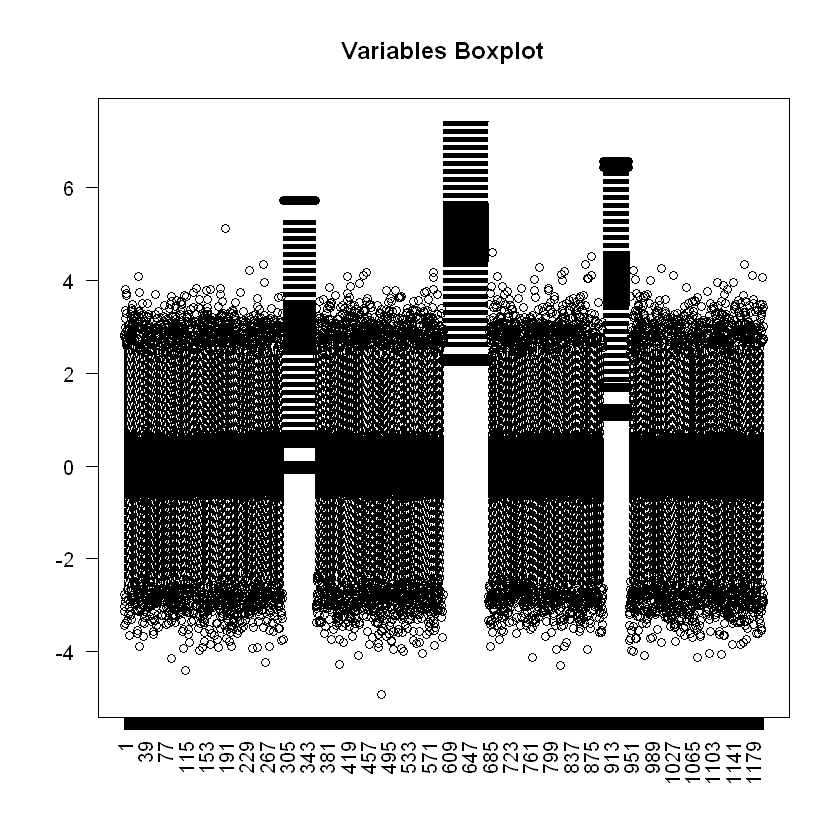

In [15]:
boxplot(oDataMatrix, las = 2, col = rainbow(ncol(oDataMatrix)), main = "Variables Boxplot")

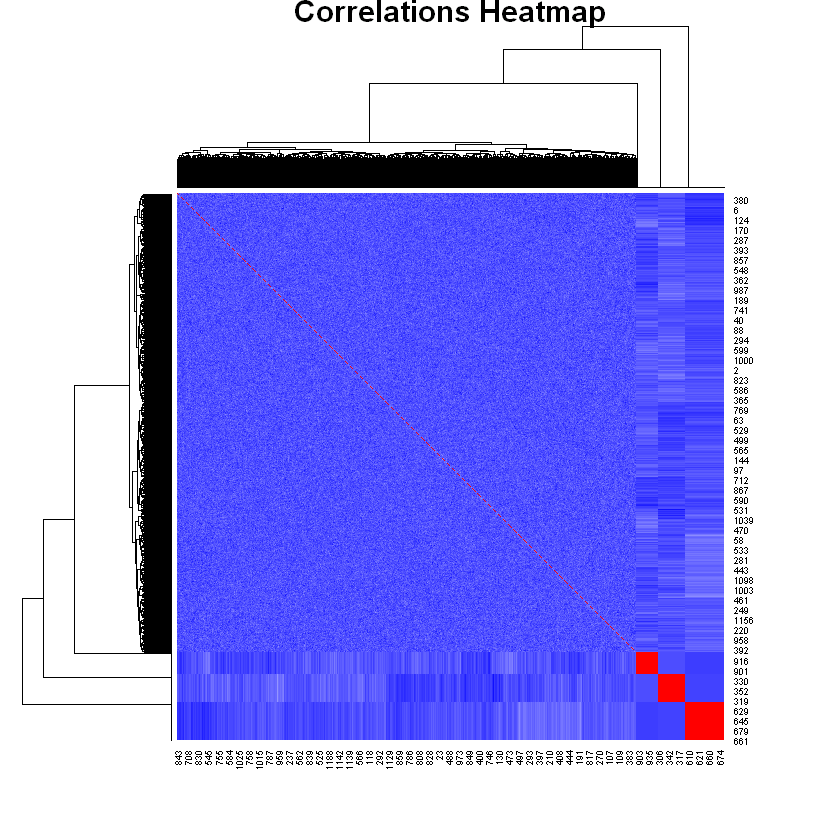

In [16]:
##########################################
# Correlation Matrix                     #
##########################################

cor_matrix <- cor(oDataMatrix)

# Correlations Heatmap
heatmap(cor_matrix, symm = TRUE, col = colorRampPalette(c("blue", "white", "red"))(100),
        main = "Correlations Heatmap")

In [ ]:
##########################################
# Histograms for each variable           #
##########################################

par(mfrow = c(3, 3))  # Arrange plots in a grid
for (col in colnames(oDataMatrix)) {
    hist(oDataMatrix[, col], main = paste("Histogram of", col), xlab = col, col = "lightblue", border = "white")
}
par(mfrow = c(1, 1))  # Reset plot layout


Importance of components:
                          PC1     PC2     PC3     PC4     PC5    PC6     PC7
Standard deviation     9.2758 7.85445 7.02080 2.27616 2.25099 2.2451 2.23845
Proportion of Variance 0.0717 0.05141 0.04108 0.00432 0.00422 0.0042 0.00418
Cumulative Proportion  0.0717 0.12311 0.16419 0.16850 0.17273 0.1769 0.18110
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     2.23286 2.21475 2.20714 2.19461 2.18849 2.18161 2.17984
Proportion of Variance 0.00415 0.00409 0.00406 0.00401 0.00399 0.00397 0.00396
Cumulative Proportion  0.18526 0.18935 0.19341 0.19742 0.20141 0.20538 0.20934
                          PC15   PC16    PC17    PC18    PC19   PC20    PC21
Standard deviation     2.17423 2.1630 2.14704 2.14515 2.13719 2.1358 2.13059
Proportion of Variance 0.00394 0.0039 0.00384 0.00383 0.00381 0.0038 0.00378
Cumulative Proportion  0.21328 0.2172 0.22102 0.22485 0.22866 0.2325 0.23624
                          PC22    PC23    

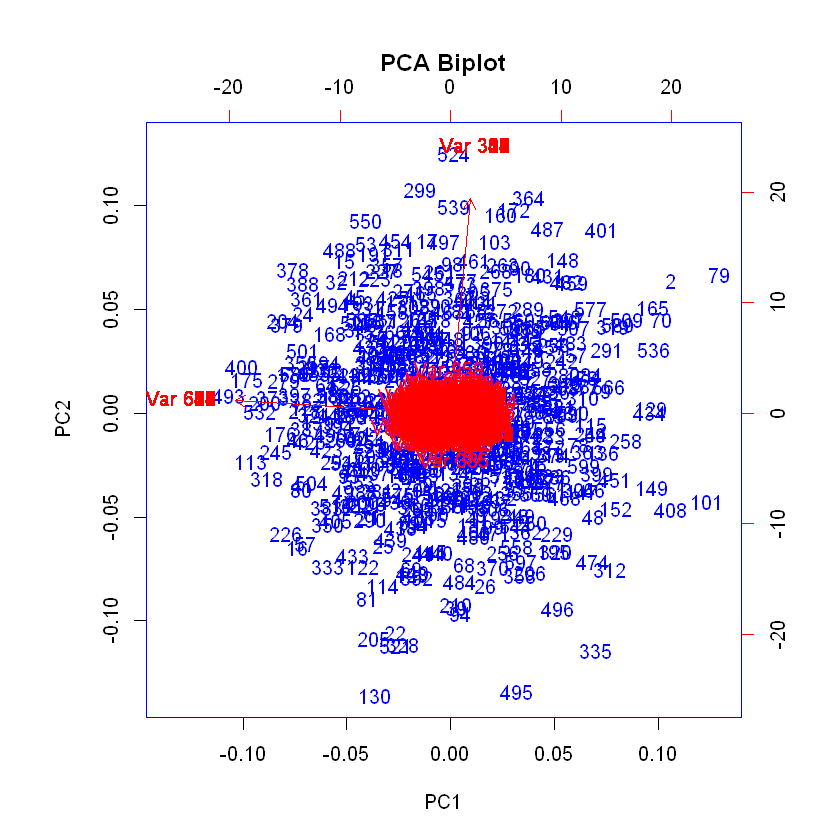

In [18]:
##########################################
# PCA Simple                             #
##########################################

pca_res <- prcomp(oDataMatrix, center = TRUE, scale. = TRUE)

# Summary of principal components
summary(pca_res)

# Biplot of the first two principal components
biplot(pca_res, main = "PCA Biplot", col = c("blue", "red"))


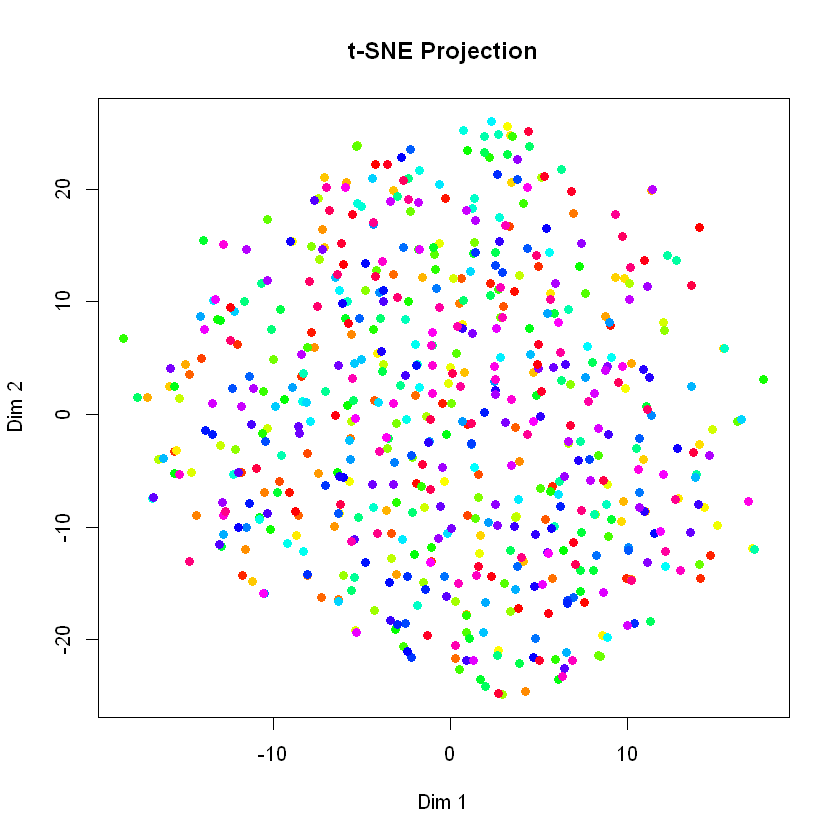

In [19]:
##########################################
# t-SNE Visualization                    #
##########################################

# Reduce dimensionality using t-SNE and visualize clusters.

if (!requireNamespace("Rtsne", quietly = TRUE)) {
    install.packages("Rtsne")
}
library(Rtsne)

# t-SNE
tsne_res <- Rtsne(oDataMatrix, dims = 2, perplexity = 15)

# Visualize t-SNE results
plot(tsne_res$Y, main = "t-SNE Projection", xlab = "Dim 1", ylab = "Dim 2",
     col = rainbow(length(tsne_res$Y[,1])), pch = 19)

In [ ]:
# Ploting first observations             #
##########################################

matplot(t(oDataMatrix[1:5, ]), type = "l", lty = 1, col = 1:5,
        main = "First observations",
        xlab = "Variables", ylab = "Amplitude")
legend("topright", legend = paste("Observation", 1:5), col = 1:5, lty = 1)

# Ploting mean of the generated signal   #
##########################################

mean_signal <- colMeans(oDataMatrix)

plot(mean_signal, type = "l", main = "Generated Signal", xlab = "Variables", ylab = "Amplitude")

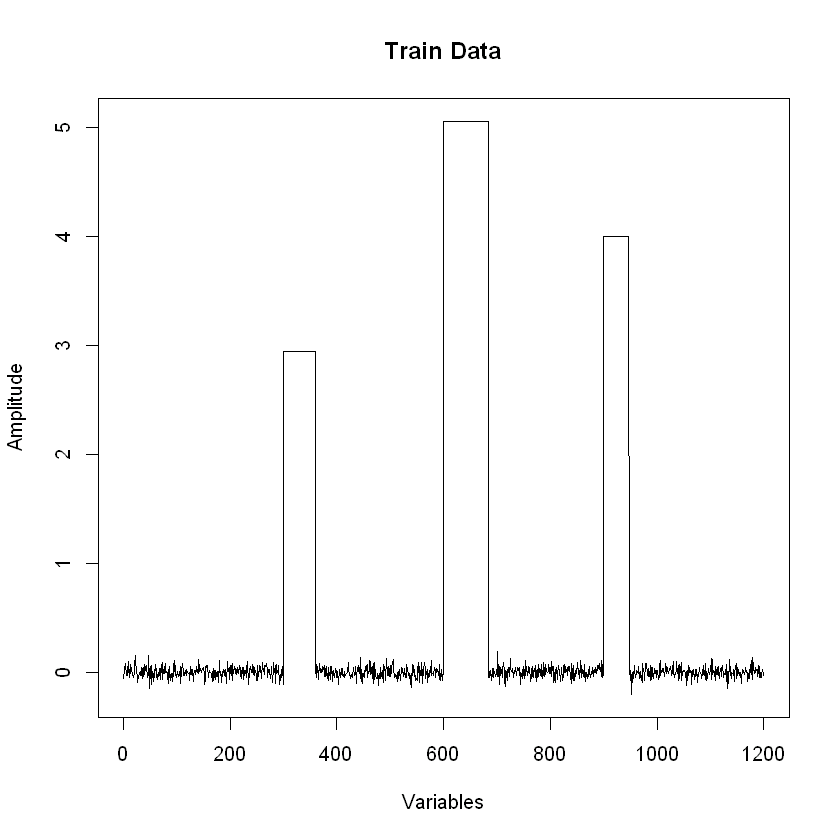

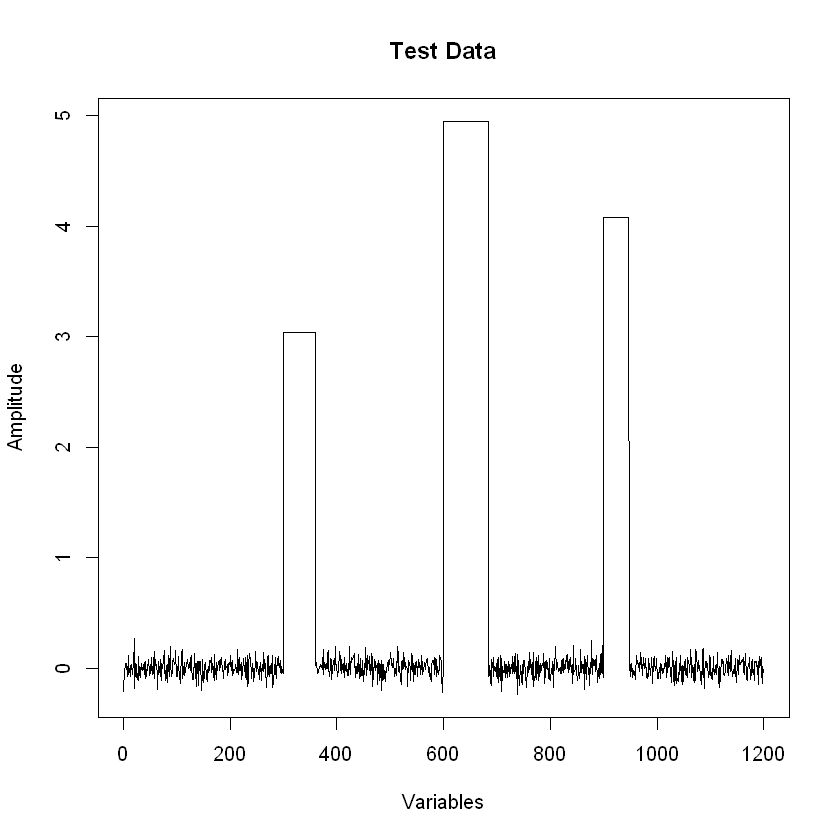

In [21]:
# Ploting mean of the generated signal   #
##########################################

mean_signal <- colMeans(oTrainData)

plot(mean_signal, type = "l", main = "Train Data", xlab = "Variables", ylab = "Amplitude")

# Ploting mean of the generated signal   #
##########################################

mean_signal <- colMeans(oTestData)

plot(mean_signal, type = "l", main = "Test Data", xlab = "Variables", ylab = "Amplitude")

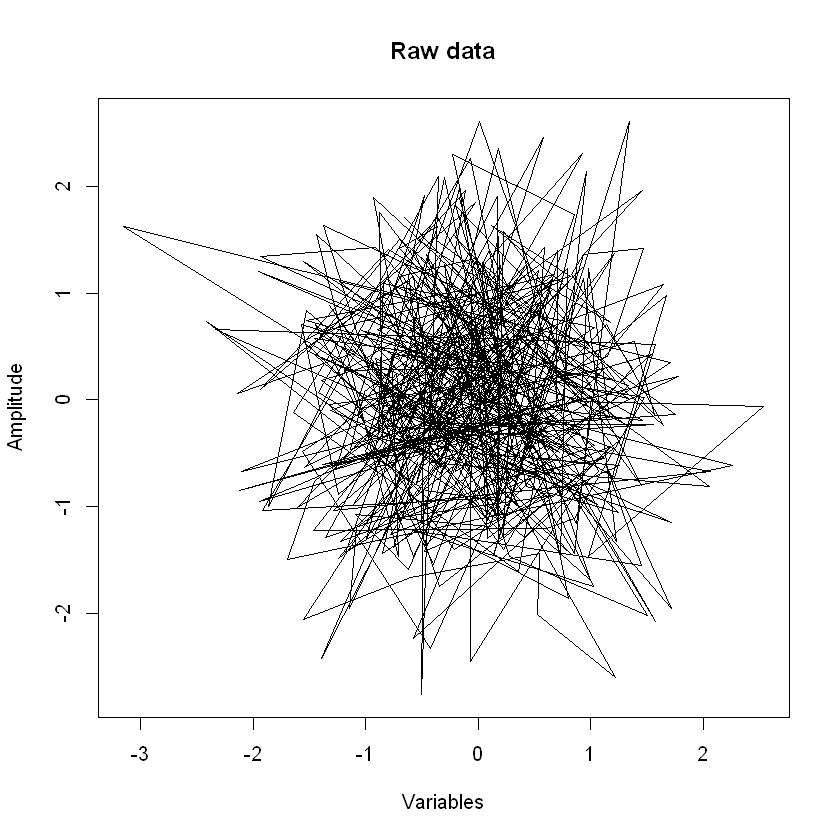

In [23]:
plot(oTrainData, type = "l", main = "Raw data", xlab = "Variables", ylab = "Amplitude")

In [25]:
Analyze_PCA <- function(X, numAxes = 50, explainedVarianceThreshold = 70) {
  pca <- prcomp(X, center = TRUE, scale. = TRUE)
  
  variance <- (pca$sdev^2 / sum(pca$sdev^2)) * 100
  cat(paste0("Variance explained by the first ", numAxes, " axes: ", sum(variance[1:numAxes]), "\n"))
  
  cum_variance <- cumsum(variance)
  
  num_components <- which(cum_variance >= explainedVarianceThreshold)[1]
  cat(paste("Number of principal components:", num_components, "to have", explainedVarianceThreshold, "% of variance\n"))
  
  d <- data.frame(PCAxes = seq_along(variance), Variance = variance, CumulativeVariance = cum_variance)

  library(ggplot2)
  p1 <- ggplot(d, aes(PCAxes, Variance)) +
    geom_col(fill = "skyblue") +
    labs(title = "Variance Explained by Each Principal Component", 
         x = "Principal Component", y = "Variance (%)") +
    theme_minimal()
  
  p2 <- ggplot(d, aes(PCAxes, CumulativeVariance)) +
    geom_line(color = "blue") +
    geom_point() +
    labs(title = "Cumulative Variance Explained", 
         x = "Principal Component", y = "Cumulative Variance (%)") +
    geom_hline(yintercept = explainedVarianceThreshold, linetype = "dashed", color = "red") +
    annotate("text", x = num_components, y = explainedVarianceThreshold + 5, 
             label = paste("Components:", num_components), color = "red") +
    theme_minimal()
  
  print(p1)
  print(p2)

  return(list(Variance = variance, CumulativeVariance = cum_variance, NumComponents = num_components))
}

[1] "Current Time : 2024-12-08 15:32:26"
Variance explained by the first 15 axes: 21.3275445838186
Number of principal components: 200 to have 70 % of variance


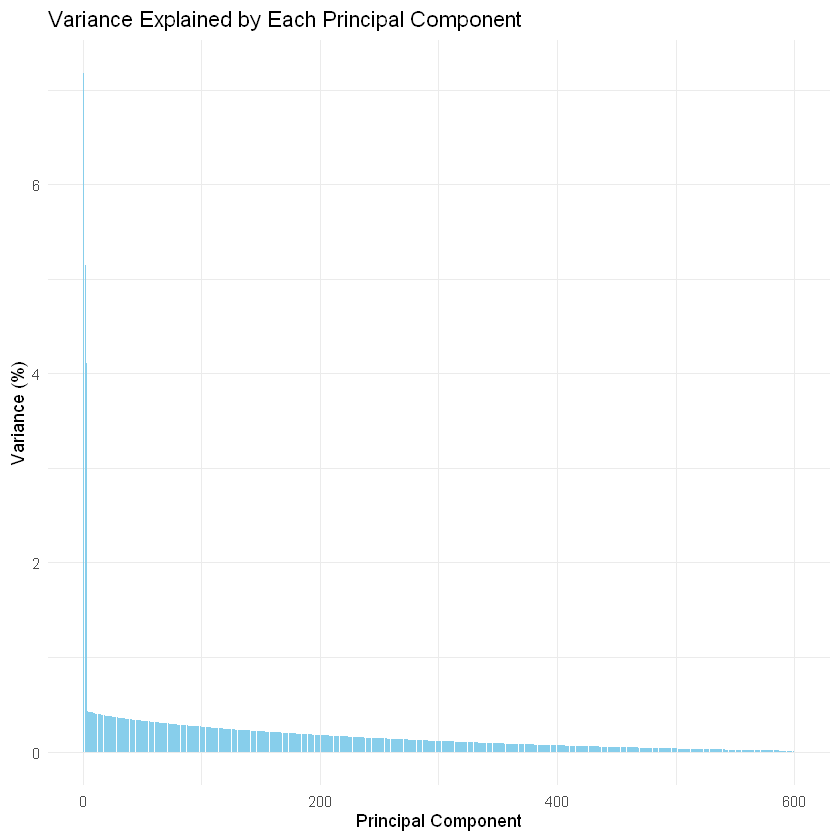

[1] "Current Time : 2024-12-08 15:32:27"
[1] "Standard PCA computation time : 1.334 seconds"


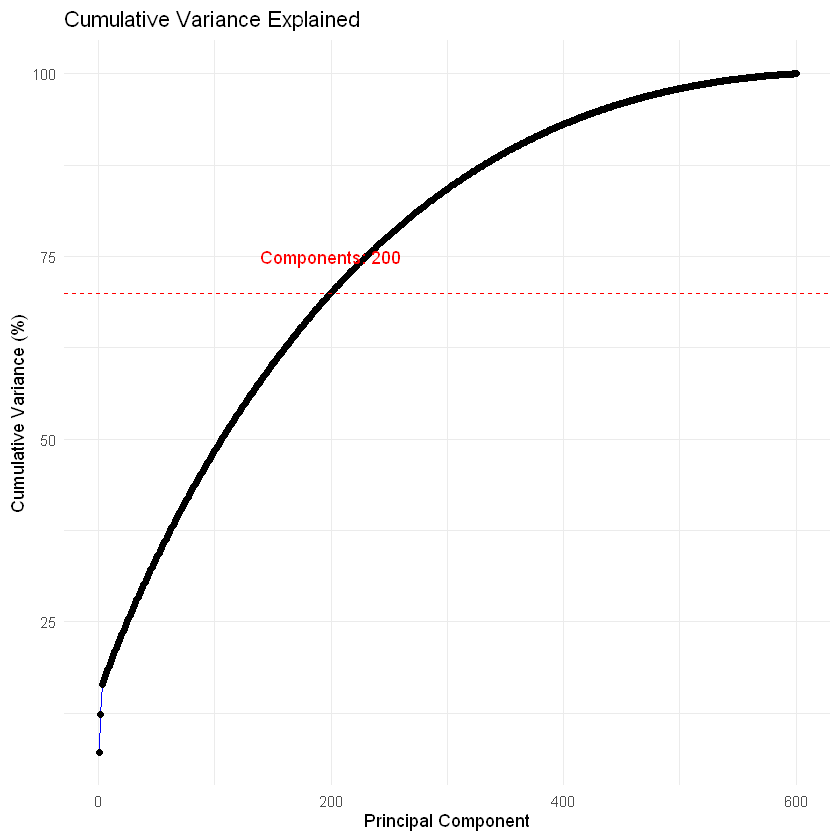

In [27]:
# PCA Exploration                        #
##########################################

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

oPCAAnalysis <- Analyze_PCA(oDataMatrix, numAxes = 15, explainedVarianceThreshold = 70)

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Standard PCA computation time :", elapsed_time, "seconds"))

In [29]:
# Create the functions to compute the evaluation criteria

Get_RMSE <- function(rActual, rPredicted) {
  if (length(rActual) != length(rPredicted)) {
    stop("Get_RMSE() - Error : Vectors rActual & rPredicted must have the same lenght.")
  }
  if (any(is.na(rActual)) || any(is.na(rPredicted))) {
    stop("Get_RMSE() - Error : Input data contains NA value(s).")
  }
  return(sqrt(mean((rActual - rPredicted)^2, na.rm = TRUE)))
}

Get_MSE <- function(rActual, rPredicted) {
  if (length(rActual) != length(rPredicted)) {
    stop("Get_MSE() - Error : Vectors rActual & rPredicted must have the same lenght.")
  }
  if (any(is.na(rActual)) || any(is.na(rPredicted))) {
    stop("Get_MSE() - Error : Input data contains NA value(s).")
  }
  return(mean((rActual - rPredicted)^2, na.rm = TRUE))
}

Get_NMSE <- function(rActual, rPredicted) {
  if (length(rActual) != length(rPredicted)) {
    stop("Get_NMSE() - Error : Vectors rActual & rPredicted must have the same lenght.")
  }
  if (any(is.na(rActual)) || any(is.na(rPredicted))) {
    stop("Get_NMSE() - Error : Input data contains NA value(s).")
  }

  rMean_Squared_Error <- sum((rActual - rPredicted)^2)
  rMean_Variance_Error <- sum((rActual - mean(rActual))^2)

  if (rMean_Variance_Error == 0) {
    warning("Get_NMSE() - Error : Division / 0.")
    return(NA)
  }

  return(rMean_Squared_Error / rMean_Variance_Error)
}

# 4. Standard PCA

In [32]:
Perform_Standard_PCA <- function(trainData, testData, numComponents = NULL, varianceThreshold = NULL) {
  
  # Step 1: Select variables based on a variance threshold
  if (!is.null(varianceThreshold)) {
    colVariances <- apply(trainData, 2, var)  
    selectedCols <- colVariances > varianceThreshold
    trainData <- trainData[, selectedCols, drop = FALSE]
    testData <- testData[, selectedCols, drop = FALSE]
  } else {
    selectedCols <- rep(TRUE, ncol(trainData))
  }

  # Step 2: Define the number of components if not specified
  if (is.null(numComponents)) {
    numComponents <- ncol(trainData)
  }

  # Preprocessing: centering and scaling the training data
  X_train_scaled <- scale(trainData, center = TRUE, scale = TRUE)
  X_mean <- attr(X_train_scaled, "scaled:center")
  X_sd <- attr(X_train_scaled, "scaled:scale")

  # Perform PCA on the preprocessed data (not on the correlation matrix)
  # Since the data is already centered/scaled, set center=FALSE and scale.=FALSE in prcomp
  oPcaResult <- prcomp(X_train_scaled, center = FALSE, scale. = FALSE)

  # Visualization (optional)
  if (ncol(oPcaResult$x) >= 2) {
    plot(oPcaResult$x[, 1:2], main = "Standard PCA", xlab = "PC1", ylab = "PC2")
  }

  # Apply the same preprocessing to the test data
  X_test_scaled <- scale(testData, center = X_mean, scale = X_sd)

  # Project the test data onto the principal components
  # predict() can also be used directly, but here it's done manually:
  oTestScores <- X_test_scaled %*% oPcaResult$rotation[, 1:numComponents]

  # Reconstruct the test data
  X_test_reconstructed_scaled <- oTestScores %*% t(oPcaResult$rotation[, 1:numComponents])

  # Return to the original scale
  X_test_reconstructed <- sweep(X_test_reconstructed_scaled, 2, X_sd, "*")
  X_test_reconstructed <- sweep(X_test_reconstructed, 2, X_mean, "+")

  # Check dimensions
  if (!all(dim(X_test_reconstructed) == dim(testData))) {
    stop("Mismatch in dimensions between testData and reconstructed data")
  }

  # Evaluation
  dRMSE <- Get_RMSE(as.vector(testData), as.vector(X_test_reconstructed))
  dMSE <- Get_MSE(as.vector(testData), as.vector(X_test_reconstructed))
  dNMSE <- Get_NMSE(as.vector(testData), as.vector(X_test_reconstructed))

  result <- list(RMSE = dRMSE, MSE = dMSE, NMSE = dNMSE)
  if (!is.null(varianceThreshold)) {
    result$ActiveVariables <- sum(selectedCols)
  } else {
    result$ActiveVariables <- numComponents
  }

  return(result)
}

[1] "Current Time : 2024-12-08 15:32:31"
[1] "Number of Components: 209"
[1] "Standard PCA - RMSE: 0.820961658767788"
[1] "Standard PCA - MSE: 0.673978045166758"
[1] "Standard PCA - NMSE: 0.200469178924063"
[1] "Current Time : 2024-12-08 15:32:32"
[1] "Standard PCA computation time : 0.984 seconds"


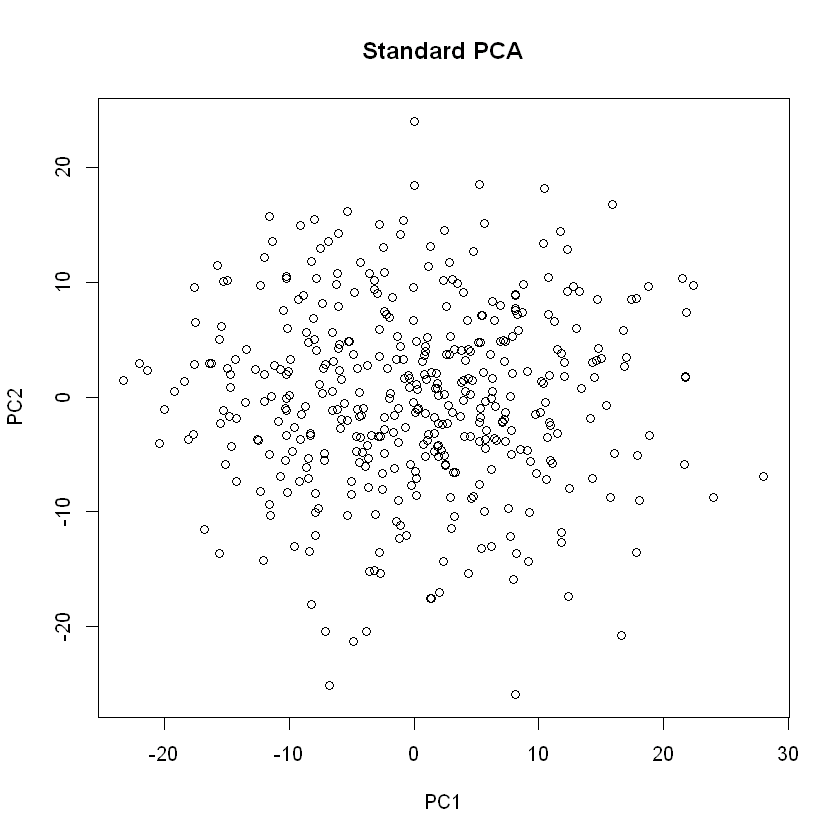

In [34]:
# Standard PCA on the Train DATASET      #
##########################################

# Cell execution time 15/11/2024 : 1.929 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# First step => Find the number of components explaining 80% of the variance
oPCAResult <- prcomp(oTrainData, center = TRUE, scale. = TRUE)
dExplained_Variance <- cumsum(oPCAResult$sdev^2) / sum(oPCAResult$sdev^2)
iNumComponents <- which(dExplained_Variance >= 0.80)[1]
print(paste("Number of Components:", iNumComponents))

# Perform Standard PCA
oStandardPCAResults <- Perform_Standard_PCA(oTrainData, oTestData, numComponents = iNumComponents, NULL)

print(paste("Standard PCA - RMSE:", oStandardPCAResults$RMSE))
print(paste("Standard PCA - MSE:", oStandardPCAResults$MSE))
print(paste("Standard PCA - NMSE:", oStandardPCAResults$NMSE))

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Standard PCA computation time :", elapsed_time, "seconds"))

# 5. PCA based on Variance Selection

[1] "Current Time : 2024-12-08 15:32:35"


$RMSE
[1] 0.7626946

$MSE
[1] 0.581703

$NMSE
[1] 0.5829039

$ActiveVariables
[1] 501

[1] "Current Time : 2024-12-08 15:32:35"
[1] "Variance Selection PCA computation time : 0.259 seconds"


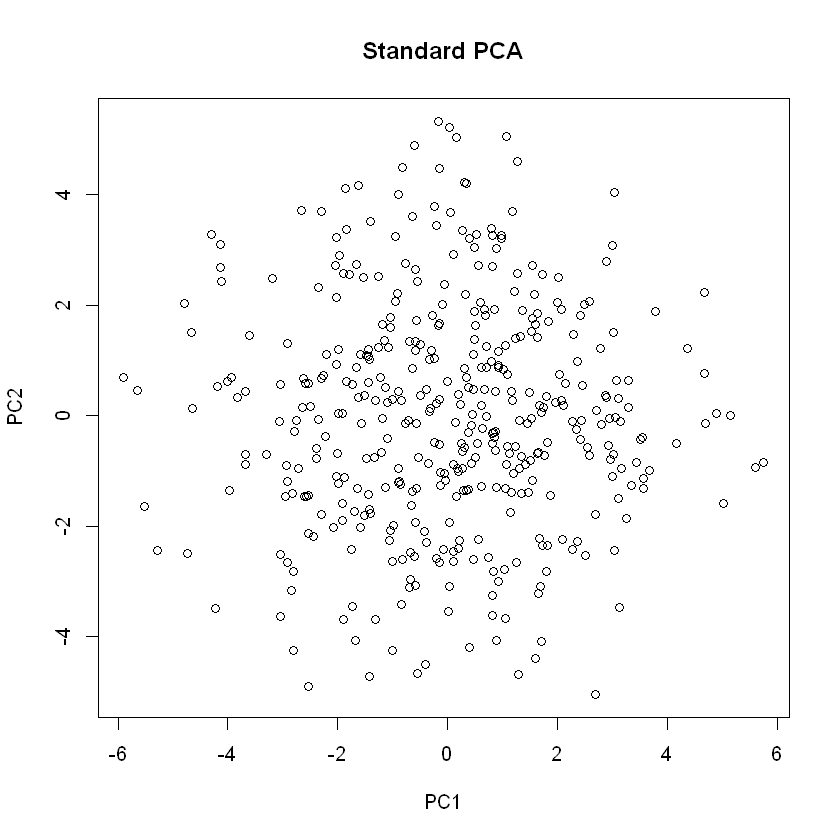

In [37]:
# Variance Selection PCA on the Train DATASET      #
####################################################

# Cell execution time 15/11/2024 : 1.929 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# Perform Variance Selection PCA
oVarPCAResults <- Perform_Standard_PCA(oTrainData, oTestData, numComponents = iNumComponents, varianceThreshold = 1)

oVarPCAResults

# Display end time and elapsed time
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Variance Selection PCA computation time :", elapsed_time, "seconds"))

# 6. Sparse PCA

In [40]:
Perform_Sparse_PCA <- function(trainData, testData, paraValues, numComponents = 1) {
  library(elasticnet)
  
  # Data frame to store numeric results
  results <- data.frame(Para = paraValues, RMSE = NA, MSE = NA, NMSE = NA, ActiveVariables = NA)
  
  # List to store loadings for each para value
  loadings_list <- list()
  
  # Parallel execution
  parallel_results <- foreach(i = 1:length(paraValues), .combine = rbind,
                              .packages = c("elasticnet"), 
                              .export = c("Get_RMSE", "Get_MSE", "Get_NMSE")) %dopar% {
    iPara <- paraValues[i]

    # HERE THE CALL WITH PRE-TREATMENT. Cor Matrix Sended to the fonction.
    # Preprocessing: scale trainData and compute covariance matrix
    X <- scale(trainData, center = TRUE, scale = TRUE)
    S <- cor(X)  # Matrice de corrélation
    # Perform Sparse PCA using the covariance matrix and type = "Gram"
    oSparsePcaResult <- spca(S, K = numComponents, sparse = "penalty", para = rep(iPara, numComponents), type = "Gram")

    # HERE THE CALL WITH RAW DATA      
    # oSparsePcaResult <- spca(trainData, K = numComponents, sparse = "penalty", para = rep(iPara, numComponents))

      
    if (!is.null(oSparsePcaResult$loadings)) {
      # Scale testData with the same parameters used for trainData
      testDataScaled <- scale(testData, 
                              center = attr(X, "scaled:center"), 
                              scale = attr(X, "scaled:scale"))
      
      # Compute scores for test data in scaled space
      oTestScores <- testDataScaled %*% oSparsePcaResult$loadings
      
      # Reconstruct scaled test data
      oReconstructedScaled <- oTestScores %*% t(oSparsePcaResult$loadings)
      
      # Unscale the reconstructed data to original scale
      # First multiply by scale, then add center back
      oReconstructedData <- sweep(oReconstructedScaled, 2, attr(X, "scaled:scale"), "*")
      oReconstructedData <- sweep(oReconstructedData, 2, attr(X, "scaled:center"), "+")

      # Evaluate metrics using the original testData scale
      dRMSE <- Get_RMSE(as.vector(testData), as.vector(oReconstructedData))
      dMSE <- Get_MSE(as.vector(testData), as.vector(oReconstructedData))
      dNMSE <- Get_NMSE(as.vector(testData), as.vector(oReconstructedData))
      
      # Count non-zero loadings
      non_zero_loadings <- sum(oSparsePcaResult$loadings != 0)
      
      cat("Para =", iPara, "- RMSE:", dRMSE, "- MSE:", dMSE, "- NMSE:", dNMSE, "- Non-zero loadings:", non_zero_loadings, "\n")
      
      # Return iteration results
      data.frame(Para = iPara, RMSE = dRMSE, MSE = dMSE, NMSE = dNMSE, ActiveVariables = non_zero_loadings)
    } else {
      cat("Para =", iPara, "- No valid loadings returned by spca\n")
      data.frame(Para = iPara, RMSE = NA, MSE = NA, NMSE = NA, ActiveVariables = NA)
    }
  }
  
  # After parallel execution, we need to retrieve loadings in sequential mode.
  # If you want consistent results, use the same approach (covariance matrix + type = "Gram") here as well.
  X <- scale(trainData, center = TRUE, scale = TRUE)
  S <- cov(X)
  for (iPara in paraValues) {
    oSparsePcaResult <- spca(S, K = numComponents, sparse = "penalty", para = rep(iPara, numComponents), type = "Gram")
    if (!is.null(oSparsePcaResult$loadings)) {
      loadings_list[[as.character(iPara)]] <- oSparsePcaResult$loadings
    } else {
      loadings_list[[as.character(iPara)]] <- NULL
    }
  }
  
  results <- parallel_results
  
  # Return a list containing the results data frame and the loadings list
  return(list(results = results, loadings = loadings_list))
}

In [42]:
##########################################
# Sparse PCA on the entire Train DATASET #
##########################################

# Cell execution time 15/11/2024 : 355.319 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# Penalty list
oParaValues <- c(1, 2, 3, 5, 10, 15, 20, 25, 30)

# Perform Sparse PCA
res <- Perform_Sparse_PCA(oTrainData, oTestData, oParaValues, numComponents = 1)

oSparsePCAResults <- res$results
loadings_list <- res$loadings


print(oSparsePCAResults[, -6])

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Sparse PCA computation time :", elapsed_time, "seconds"))

[1] "Current Time : 2024-12-08 15:32:39"
  Para      RMSE       MSE      NMSE ActiveVariables
1    1 0.9561195 0.9141645 0.2719106              84
2    2 0.9561196 0.9141648 0.2719107              84
3    3 0.9561198 0.9141651 0.2719108              84
4    5 0.9561202 0.9141659 0.2719111              84
5   10 0.9561229 0.9141709 0.2719126              84
6   15 0.9561437 0.9142107 0.2719244              84
7   20 0.9806393 0.9616534 0.2860358               0
8   25 0.9806393 0.9616534 0.2860358               0
9   30 0.9806393 0.9616534 0.2860358               0
[1] "Current Time : 2024-12-08 15:34:22"
[1] "Sparse PCA computation time : 102.308 seconds"


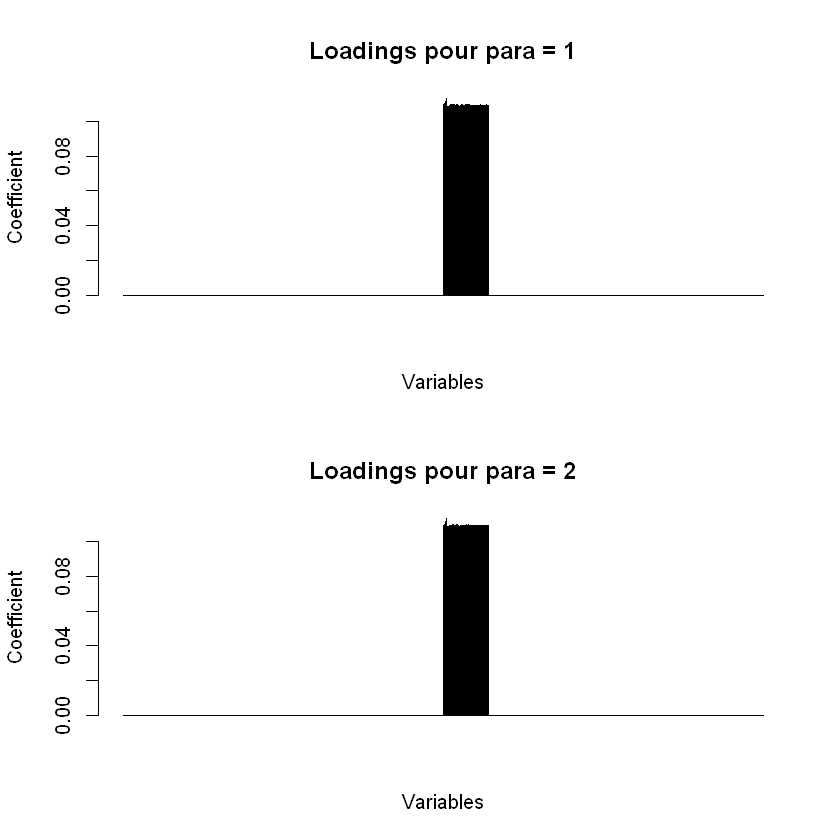

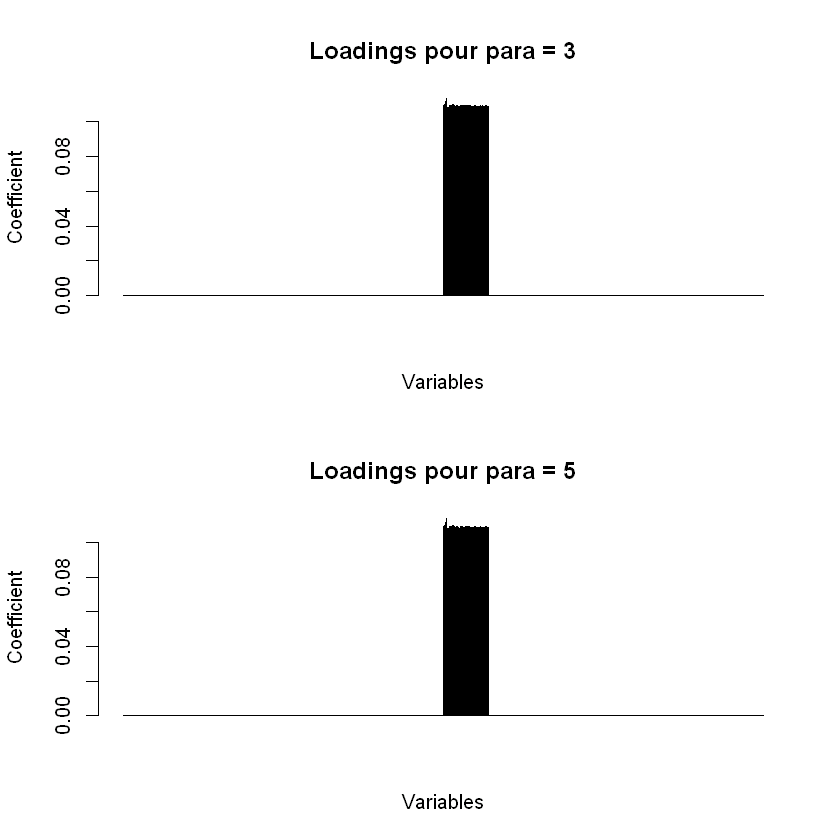

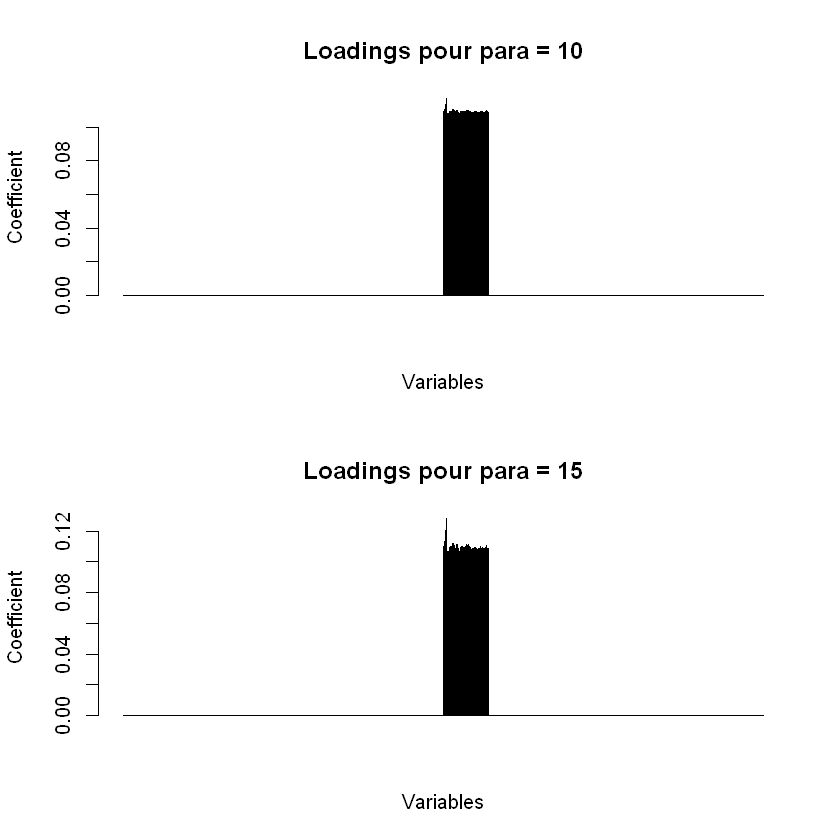

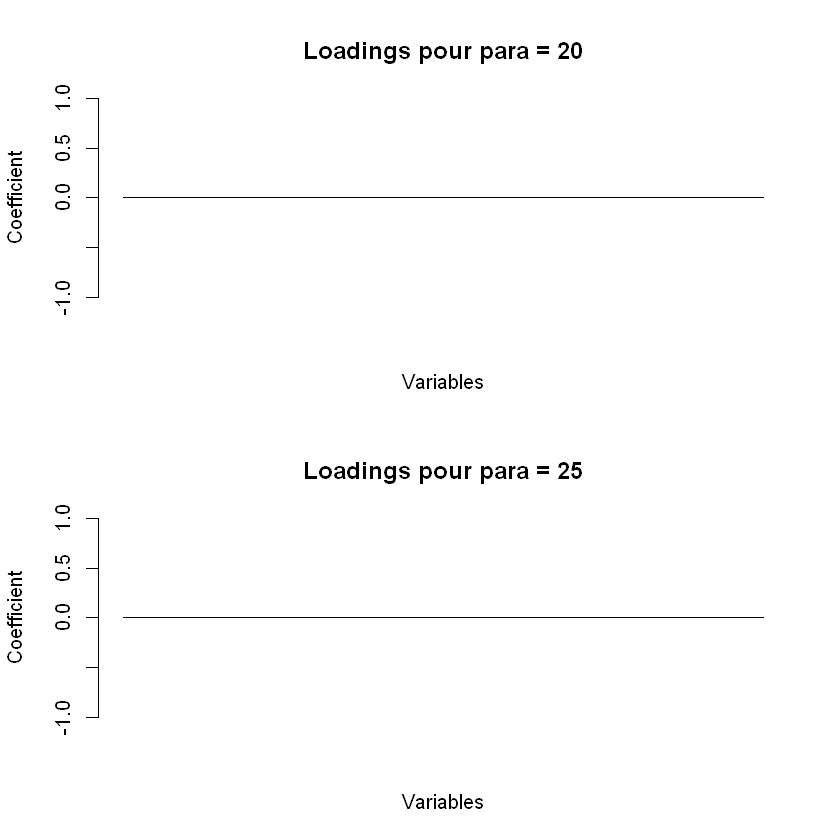

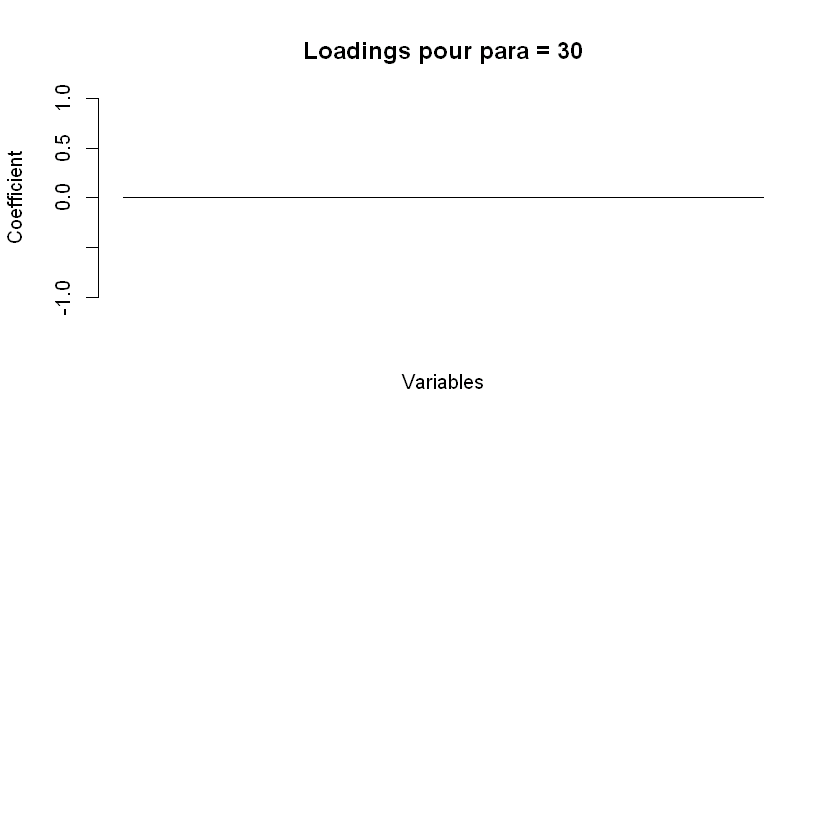

In [44]:
##########################################
# Sparse PCA Loadings Visual             #
##########################################

par(mfrow = c(ceiling(length(oParaValues)/6), 1))

for (iPara in oParaValues) {
  loadings <- loadings_list[[as.character(iPara)]]
  
  if (!is.null(loadings)) {
    barplot(loadings[, 1], main = paste("Loadings pour para =", iPara),
            xlab = "Variables", ylab = "Coefficient")
  } else {
    plot.new()
    title(main = paste("Pas de loadings pour para =", iPara))
  }
}

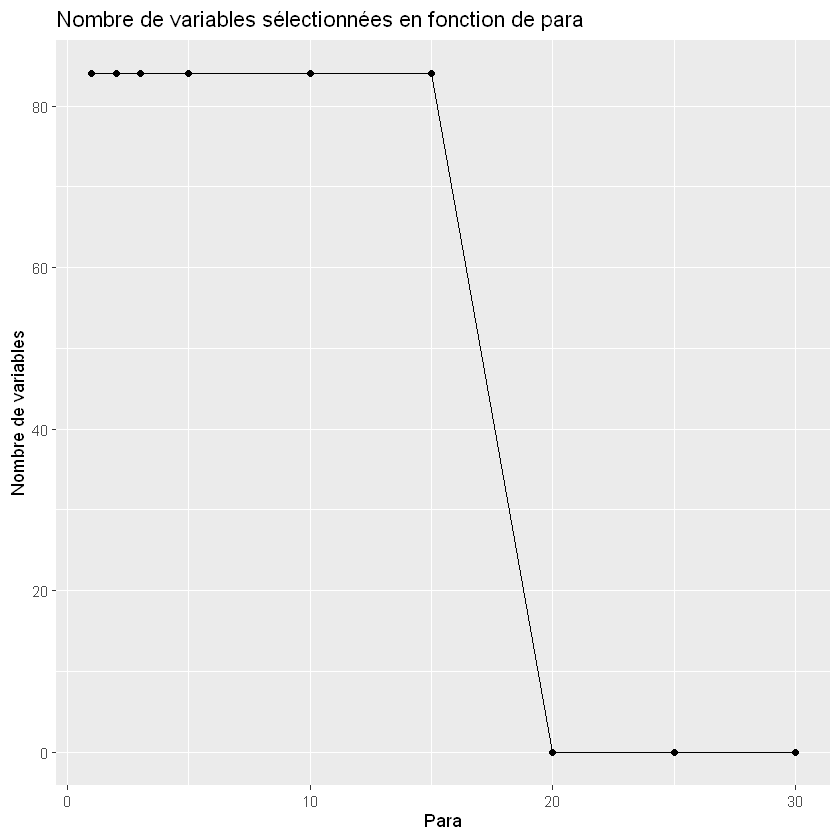

In [46]:
ggplot(oSparsePCAResults, aes(x = Para, y = ActiveVariables)) +
  geom_point() +
  geom_line() +
  labs(title = "Nombre de variables sélectionnées en fonction de para", x = "Para", y = "Nombre de variables")

In [48]:
# Sparse PCA : Showing the best result  #
#########################################

# Cell execution time 15/11/2024 : 355.319 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

library(elasticnet)

variances <- apply(oTrainData, 2, var)

k <- 60 # Varaiables to keep
top_var_indices <- order(variances, decreasing = TRUE)[1:k]
x_reduced <- oTrainData[, top_var_indices]  # Jeu de données réduit

pca_sparse <- prcomp(x_reduced, center = TRUE, scale. = TRUE)

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Sparse PCA computation time :", elapsed_time, "seconds"))

[1] "Current Time : 2024-12-08 15:36:03"
[1] "Current Time : 2024-12-08 15:36:03"
[1] "Sparse PCA computation time : 0.061 seconds"


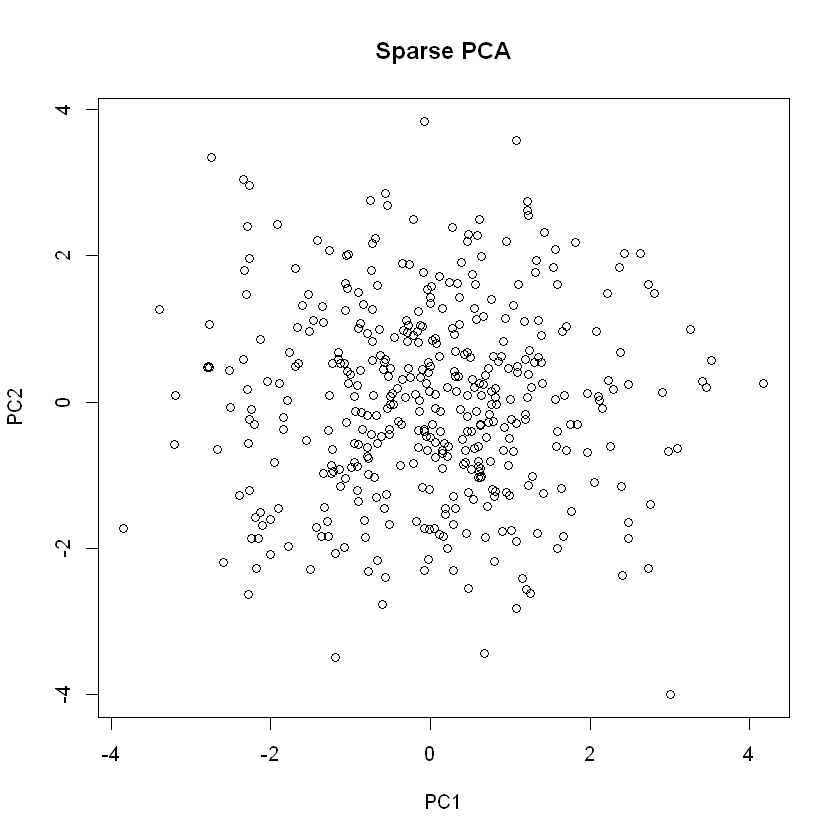

In [50]:
plot(pca_sparse$x[, 1:2], main = "Sparse PCA",
     xlab = "PC1", ylab = "PC2")

# THRESHOLD PCA

In [53]:
Perform_Threshold_PCA <- function(trainData, testData, thresholdValues, numComponents = 1) {
  results <- data.frame(Threshold = thresholdValues, RMSE = NA, MSE = NA, NMSE = NA, ActiveVariables = NA)
  
  # Parallel execution with exported functions
  results <- foreach(i = 1:length(thresholdValues), .combine = rbind, 
                     .packages = c("stats"), 
                     .export = c("Get_RMSE", "Get_MSE", "Get_NMSE")) %dopar% {
    dThreshold <- thresholdValues[i]
    
    # Selecting variables with variance above the threshold
    oVariances <- apply(trainData, 2, var)
    oSelectedIndices <- which(oVariances > dThreshold)
    ActiveVariables <- length(oSelectedIndices)
    
    if (ActiveVariables > 0) {
      # Subset of selected variables
      oTrainDataSelected <- trainData[, oSelectedIndices, drop = FALSE]
      oTestDataSelected <- testData[, oSelectedIndices, drop = FALSE]

      # Centering and scaling on the selected training data
      X_train_selected_scaled <- scale(oTrainDataSelected, center = TRUE, scale = TRUE)
      X_mean <- attr(X_train_selected_scaled, "scaled:center")
      X_sd <- attr(X_train_selected_scaled, "scaled:scale")

      # PCA on the preprocessed selected data
      # Set center=FALSE, scale.=FALSE since centering/scaling is done manually
      oPcaResult <- prcomp(X_train_selected_scaled, center = FALSE, scale. = FALSE)

      # Apply the same preprocessing to the selected test data
      X_test_selected_scaled <- scale(oTestDataSelected, center = X_mean, scale = X_sd)
      
      # Project test data onto principal components
      oTestScores <- X_test_selected_scaled %*% oPcaResult$rotation[, 1:min(numComponents, ActiveVariables), drop = FALSE]

      # Reconstruct in scaled form
      X_test_reconstructed_selected_scaled <- oTestScores %*% t(oPcaResult$rotation[, 1:min(numComponents, ActiveVariables), drop = FALSE])

      # Return to the original scale for the selected subset
      X_test_reconstructed_selected <- sweep(X_test_reconstructed_selected_scaled, 2, X_sd, "*")
      X_test_reconstructed_selected <- sweep(X_test_reconstructed_selected, 2, X_mean, "+")

      # Place the reconstructed subset back into the full matrix (non-selected variables = 0)
      oReconstructedFull <- matrix(0, nrow = nrow(testData), ncol = ncol(testData))
      oReconstructedFull[, oSelectedIndices] <- X_test_reconstructed_selected

      # Evaluation
      dRMSE <- Get_RMSE(as.vector(testData), as.vector(oReconstructedFull))
      dMSE <- Get_MSE(as.vector(testData), as.vector(oReconstructedFull))
      dNMSE <- Get_NMSE(as.vector(testData), as.vector(oReconstructedFull))
      
      # Store results
      result_row <- data.frame(Threshold = dThreshold, RMSE = dRMSE, MSE = dMSE, NMSE = dNMSE, ActiveVariables = ActiveVariables)
      
      cat("Threshold =", dThreshold, "- RMSE:", dRMSE, "- MSE:", dMSE, "- NMSE:", dNMSE, "- Num Variables:", ActiveVariables, "\n")
    } else {
      cat("Threshold =", dThreshold, "- No variables selected\n")
      result_row <- data.frame(Threshold = dThreshold, RMSE = NA, MSE = NA, NMSE = NA, ActiveVariables = 0)
    }
    
    result_row
  }
  
  return(results)
}

In [55]:
# Threshold PCA on the entire DATASET 01   #
############################################

# Cell execution time 15/11/2024 : 13.563 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# Threshold list
thresholdValues <- seq(0.05, 1.5, by = 0.05)

# Perform Threshold PCA
oThresholdPCAResults <- Perform_Threshold_PCA(oTrainData, oTestData, thresholdValues, numComponents = 1)

print(oThresholdPCAResults)

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Threshold PCA computation time :", elapsed_time, "seconds"))

[1] "Current Time : 2024-12-08 15:36:07"
   Threshold      RMSE       MSE      NMSE ActiveVariables
1       0.05 0.9566121 0.9151067 0.2721909            1200
2       0.10 0.9566121 0.9151067 0.2721909            1200
3       0.15 0.9566121 0.9151067 0.2721909            1200
4       0.20 0.9566121 0.9151067 0.2721909            1200
5       0.25 0.9566121 0.9151067 0.2721909            1200
6       0.30 0.9566121 0.9151067 0.2721909            1200
7       0.35 0.9566121 0.9151067 0.2721909            1200
8       0.40 0.9566121 0.9151067 0.2721909            1200
9       0.45 0.9566121 0.9151067 0.2721909            1200
10      0.50 0.9566121 0.9151067 0.2721909            1200
11      0.55 0.9566121 0.9151067 0.2721909            1200
12      0.60 0.9566121 0.9151067 0.2721909            1200
13      0.65 0.9566121 0.9151067 0.2721909            1200
14      0.70 0.9566121 0.9151067 0.2721909            1200
15      0.75 0.9566121 0.9151067 0.2721909            1200
16      0.80 1.

Warning message:
"Removed 6 rows containing missing values or values outside the scale range (`geom_point()`)."
Warning message:
"Removed 6 rows containing missing values or values outside the scale range (`geom_line()`)."


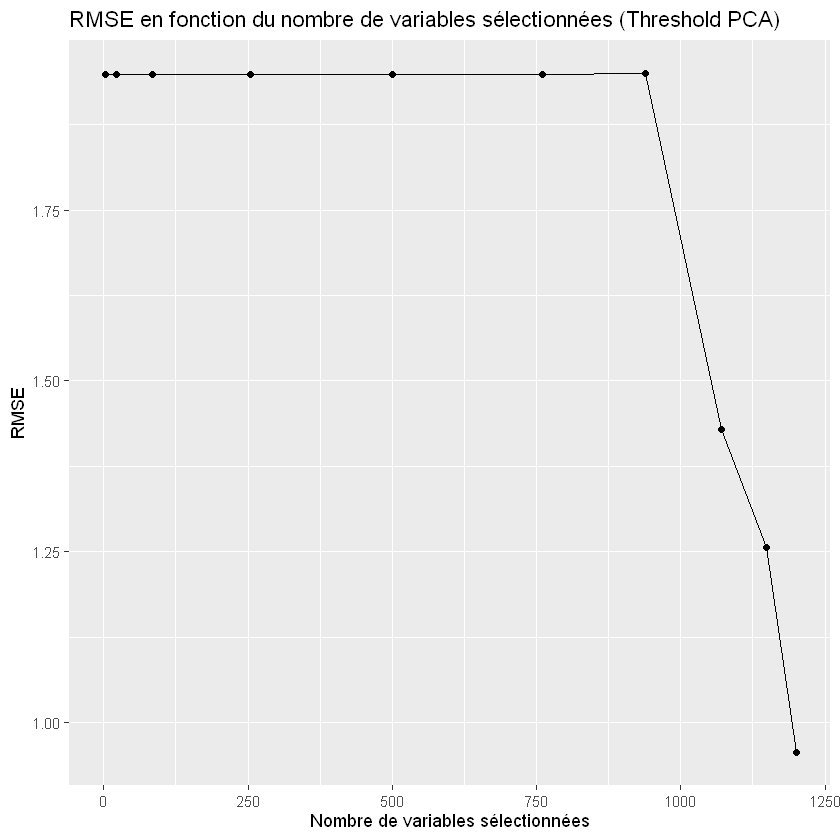

In [57]:
ggplot(oThresholdPCAResults, aes(x = ActiveVariables, y = RMSE)) +
  geom_point() +
  geom_line() +
  labs(title = "RMSE en fonction du nombre de variables sélectionnées (Threshold PCA)",
       x = "Nombre de variables sélectionnées", y = "RMSE")

Warning message:
"Removed 6 rows containing missing values or values outside the scale range (`geom_point()`)."
Warning message:
"Removed 6 rows containing missing values or values outside the scale range (`geom_line()`)."


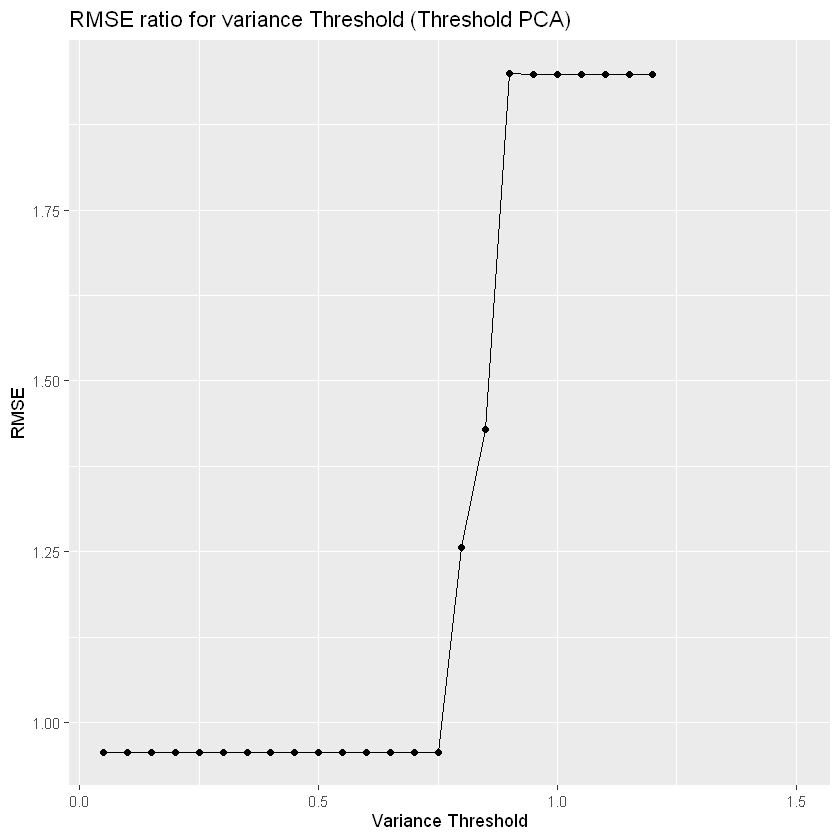

In [59]:
ggplot(oThresholdPCAResults, aes(x = Threshold, y = RMSE)) +
  geom_point() +
  geom_line() +
  labs(title = "RMSE ratio for variance Threshold (Threshold PCA)",
       x = "Variance Threshold", y = "RMSE")

# 7. RESULTS

In [62]:
# Merging results array                 #
#########################################

library(reshape2)
library(tidyr)

# Convert named lists to numeric values
oStandardPCAResults$RMSE <- as.numeric(oStandardPCAResults$RMSE)
oStandardPCAResults$MSE <- as.numeric(oStandardPCAResults$MSE)
oStandardPCAResults$NMSE <- as.numeric(oStandardPCAResults$NMSE)
oVarPCAResults$RMSE <- as.numeric(oVarPCAResults$RMSE)
oVarPCAResults$MSE <- as.numeric(oVarPCAResults$MSE)
oVarPCAResults$NMSE <- as.numeric(oVarPCAResults$NMSE)
oSparsePCAResults$RMSE <- sapply(oSparsePCAResults$RMSE, as.numeric)
oSparsePCAResults$MSE <- sapply(oSparsePCAResults$MSE, as.numeric)
oSparsePCAResults$NMSE <- sapply(oSparsePCAResults$NMSE, as.numeric)
oThresholdPCAResults$RMSE <- sapply(oThresholdPCAResults$RMSE, as.numeric)
oThresholdPCAResults$MSE <- sapply(oThresholdPCAResults$MSE, as.numeric)
oThresholdPCAResults$NMSE <- sapply(oThresholdPCAResults$NMSE, as.numeric)

# New data frames
standardPCAResultsDF <- data.frame(Method = "Standard PCA", Parameter = 0, 
                                   RMSE = round(oStandardPCAResults$RMSE, 4), 
                                   MSE = round(oStandardPCAResults$MSE, 4), 
                                   NMSE = round(oStandardPCAResults$NMSE, 4),
                                   ActiveVariables = unlist(oStandardPCAResults$ActiveVariables))

variancePCAResultsDF <- data.frame(Method = "Variance PCA", Parameter = 0, 
                                   RMSE = round(oVarPCAResults$RMSE, 4), 
                                   MSE = round(oVarPCAResults$MSE, 4), 
                                   NMSE = round(oVarPCAResults$NMSE, 4),
                                   ActiveVariables = unlist(oVarPCAResults$ActiveVariables))

sparsePCAResultsDF <- data.frame(Method = "Sparse PCA", Parameter = oSparsePCAResults$Para, 
                                 RMSE = round(unlist(oSparsePCAResults$RMSE), 4), 
                                 MSE = round(unlist(oSparsePCAResults$MSE), 4), 
                                 NMSE = round(unlist(oSparsePCAResults$NMSE), 4),
                                 ActiveVariables = unlist(oSparsePCAResults$ActiveVariables))

thresholdPCAResultsDF <- data.frame(Method = "Threshold PCA", Parameter = oThresholdPCAResults$Threshold, 
                                    RMSE = round(unlist(oThresholdPCAResults$RMSE), 4), 
                                    MSE = round(unlist(oThresholdPCAResults$MSE), 4), 
                                    NMSE = round(unlist(oThresholdPCAResults$NMSE), 4),
                                    ActiveVariables = unlist(oThresholdPCAResults$ActiveVariables))                                    

# Combine all results
allResults <- rbind(standardPCAResultsDF, variancePCAResultsDF, sparsePCAResultsDF, thresholdPCAResultsDF)

# Cleaning
allResults$Parameter <- replace_na(allResults$Parameter, 0)

# Calculate Global_Score with rounded values
allResults <- allResults %>%
  mutate(Global_Score = round((RMSE + MSE + NMSE) / 3, 4))

print(allResults)

          Method Parameter   RMSE    MSE   NMSE ActiveVariables Global_Score
1   Standard PCA      0.00 0.8210 0.6740 0.2005             209       0.5652
2   Variance PCA      0.00 0.7627 0.5817 0.5829             501       0.6424
3     Sparse PCA      1.00 0.9561 0.9142 0.2719              84       0.7141
4     Sparse PCA      2.00 0.9561 0.9142 0.2719              84       0.7141
5     Sparse PCA      3.00 0.9561 0.9142 0.2719              84       0.7141
6     Sparse PCA      5.00 0.9561 0.9142 0.2719              84       0.7141
7     Sparse PCA     10.00 0.9561 0.9142 0.2719              84       0.7141
8     Sparse PCA     15.00 0.9561 0.9142 0.2719              84       0.7141
9     Sparse PCA     20.00 0.9806 0.9617 0.2860               0       0.7428
10    Sparse PCA     25.00 0.9806 0.9617 0.2860               0       0.7428
11    Sparse PCA     30.00 0.9806 0.9617 0.2860               0       0.7428
12 Threshold PCA      0.05 0.9566 0.9151 0.2722            1200       0.7146

In [102]:
library(dplyr)
library(ggplot2)

sortedResults <- allResults %>%
  arrange(NMSE) 

print(sortedResults)

bestMethod <- sortedResults %>%
  slice(1)  

cat("The best method is:", bestMethod$Method, "with a NMSE of", bestMethod$NMSE, "\n")

          Method Parameter   RMSE    MSE   NMSE ActiveVariables Global_Score
1   Standard PCA      0.00 0.8210 0.6740 0.2005             209       0.5652
2     Sparse PCA      1.00 0.9561 0.9142 0.2719              84       0.7141
3     Sparse PCA      2.00 0.9561 0.9142 0.2719              84       0.7141
4     Sparse PCA      3.00 0.9561 0.9142 0.2719              84       0.7141
5     Sparse PCA      5.00 0.9561 0.9142 0.2719              84       0.7141
6     Sparse PCA     10.00 0.9561 0.9142 0.2719              84       0.7141
7     Sparse PCA     15.00 0.9561 0.9142 0.2719              84       0.7141
8  Threshold PCA      0.05 0.9566 0.9151 0.2722            1200       0.7146
9  Threshold PCA      0.10 0.9566 0.9151 0.2722            1200       0.7146
10 Threshold PCA      0.15 0.9566 0.9151 0.2722            1200       0.7146
11 Threshold PCA      0.20 0.9566 0.9151 0.2722            1200       0.7146
12 Threshold PCA      0.25 0.9566 0.9151 0.2722            1200       0.7146

# A tibble: 4 × 7
  Method        Parameter  RMSE   MSE  NMSE ActiveVariables Global_Score
  <chr>             <dbl> <dbl> <dbl> <dbl>           <dbl>        <dbl>
1 Sparse PCA         1    0.956 0.914 0.272              84        0.714
2 Standard PCA       0    0.821 0.674 0.200             209        0.565
3 Threshold PCA      0.05 0.957 0.915 0.272            1200        0.715
4 Variance PCA       0    0.763 0.582 0.583             501        0.642


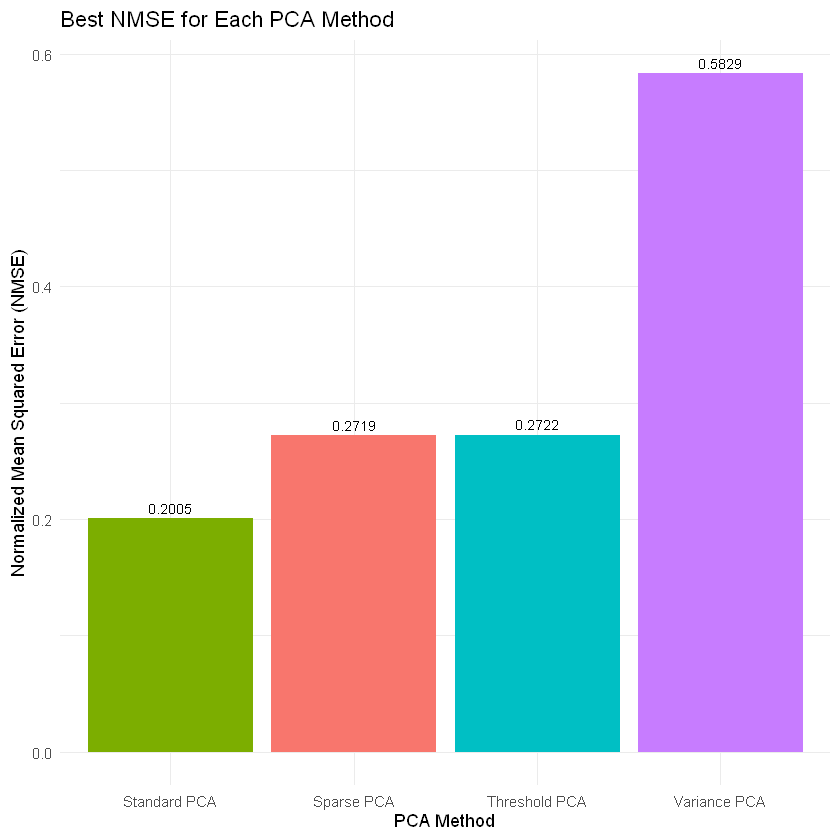

In [68]:
bestResults <- allResults %>%
  group_by(Method) %>%
  filter(NMSE == min(NMSE, na.rm = TRUE)) %>%
  slice(1) %>%
  ungroup()

print(bestResults)

ggplot(bestResults, aes(x = reorder(Method, NMSE), y = NMSE, fill = Method)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Best NMSE for Each PCA Method",
    x = "PCA Method",
    y = "Normalized Mean Squared Error (NMSE)"
  ) +
  theme_minimal() +
  theme(legend.position = "none") +
  geom_text(aes(label = round(NMSE, 4)), vjust = -0.5, size = 3)

Warning message:
"Removed 6 rows containing missing values or values outside the scale range (`geom_point()`)."
Warning message:
"Removed 6 rows containing missing values or values outside the scale range (`geom_line()`)."


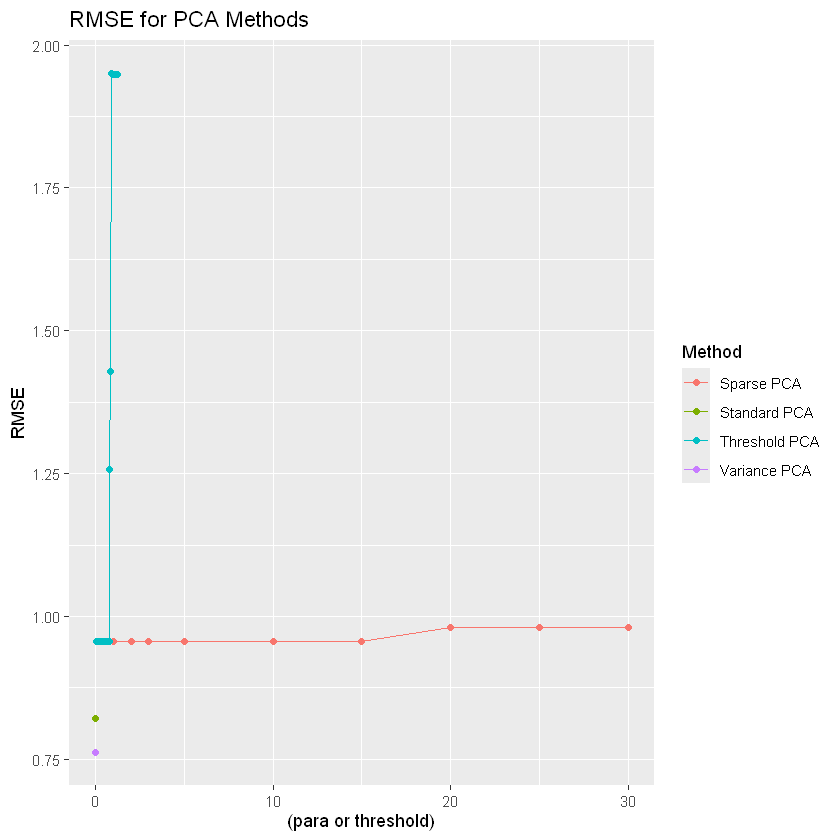

In [70]:
ggplot(allResults, aes(x = Parameter, y = RMSE, color = Method)) +
  geom_point() +
  geom_line() +
  labs(title = "RMSE for PCA Methods", x = "(para or threshold)", y = "RMSE")

In [72]:
# Computing a score                     #
#########################################

summaryDF <- allResults %>%
  group_by(Method) %>%
  summarise(
    Mean_RMSE = mean(RMSE),
    Mean_MSE = mean(MSE),
    Mean_NMSE = mean(NMSE)
  )

summaryDF <- summaryDF %>%
  mutate(Global_Score = (Mean_RMSE + Mean_MSE + Mean_NMSE) / 3)

print(summaryDF %>% arrange(Global_Score))  # Sorted by best global score...

# A tibble: 4 × 5
  Method        Mean_RMSE Mean_MSE Mean_NMSE Global_Score
  <chr>             <dbl>    <dbl>     <dbl>        <dbl>
1 Standard PCA      0.821    0.674     0.200        0.565
2 Variance PCA      0.763    0.582     0.583        0.642
3 Sparse PCA        0.964    0.930     0.277        0.724
4 Threshold PCA    NA       NA        NA           NA    


Warning message:
"Removed 18 rows containing missing values or values outside the scale range (`geom_line()`)."
Warning message:
"Removed 18 rows containing missing values or values outside the scale range (`geom_point()`)."


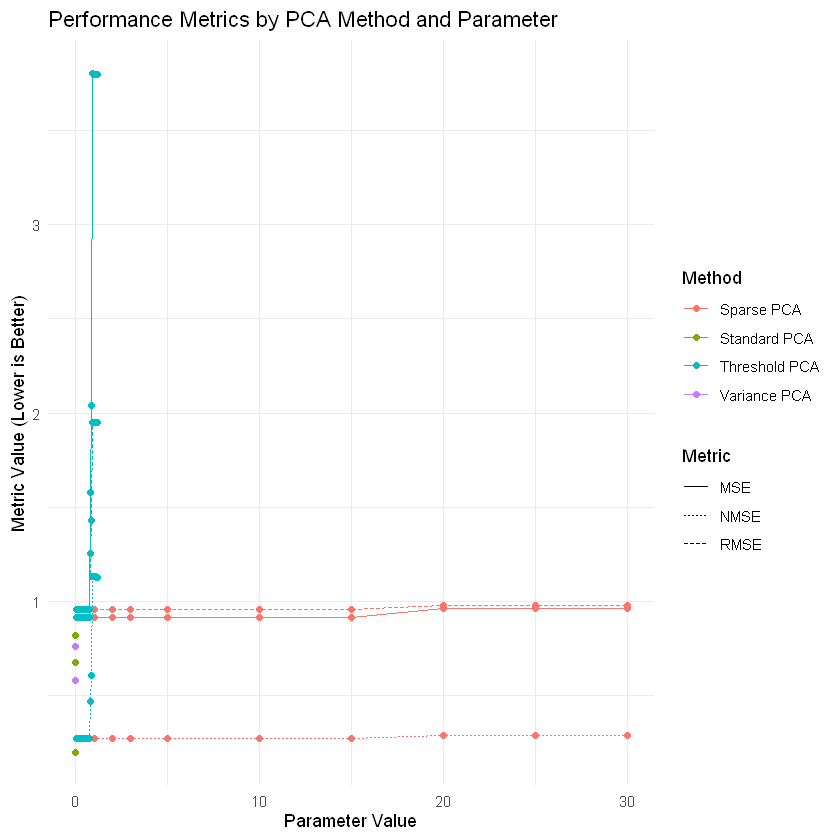

In [74]:
library(tidyr)

allResultsLong <- allResults %>%
  pivot_longer(cols = c("RMSE", "MSE", "NMSE"), names_to = "Metric", values_to = "Value")

ggplot(allResultsLong, aes(x = Parameter, y = Value, color = Method)) +
  geom_line(aes(linetype = Metric)) +
  geom_point() +
  labs(title = "Performance Metrics by PCA Method and Parameter",
       x = "Parameter Value",
       y = "Metric Value (Lower is Better)") +
  theme_minimal()

Warning message:
"Removed 6 rows containing missing values or values outside the scale range (`geom_line()`)."
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
Warning message:
"Removed 6 rows containing missing values or values outside the scale range (`geom_point()`)."


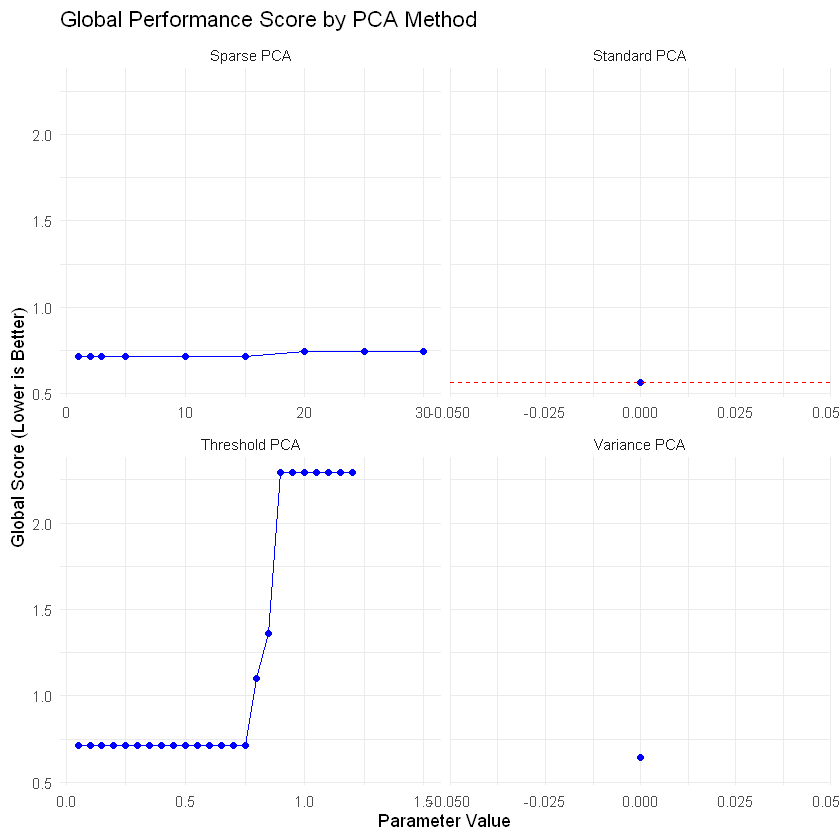

In [76]:
library(dplyr)
library(ggplot2)

# Compute vertical scale
global_min <- min(allResults$Global_Score, na.rm = TRUE)
global_max <- max(allResults$Global_Score, na.rm = TRUE)

ggplot(allResults, aes(x = Parameter, y = Global_Score)) +
  geom_line(aes(group = Method), color = "blue") +
  geom_point(color = "blue") +
  geom_hline(data = allResults %>% filter(Method == "Standard PCA"),
             aes(yintercept = Global_Score), linetype = "dashed", color = "red") +
  facet_wrap(~ Method, scales = "free_x") +
  labs(title = "Global Performance Score by PCA Method",
       x = "Parameter Value",
       y = "Global Score (Lower is Better)") +
  theme_minimal() +
  coord_cartesian(ylim = c(global_min, global_max))


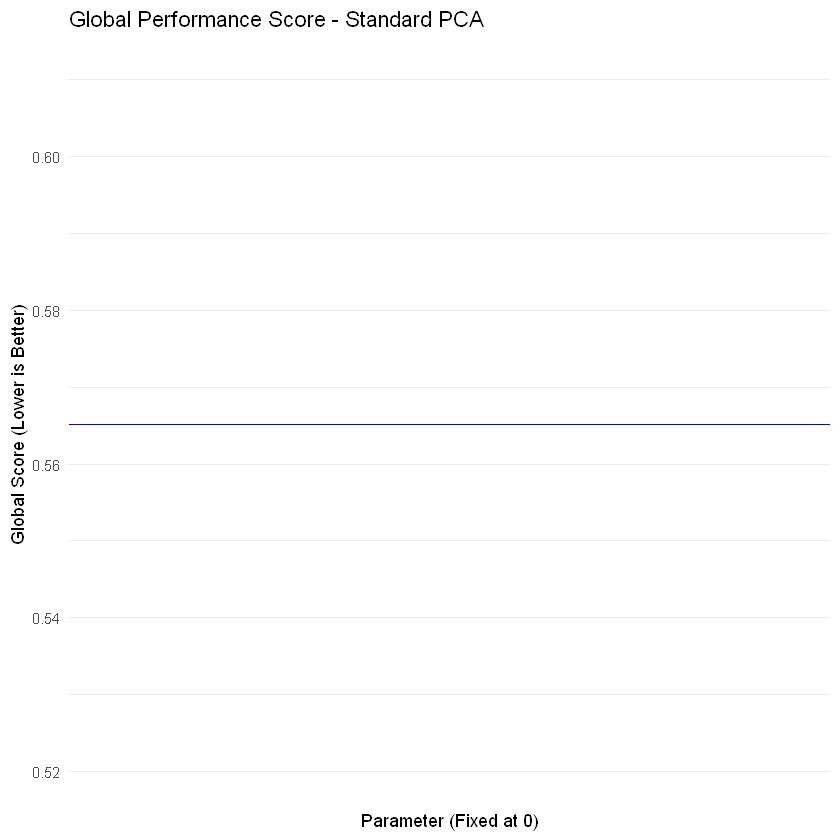

In [78]:
# Standard PCA
standardPCA <- allResults %>% filter(Method == "Standard PCA")

ggplot(standardPCA, aes(x = Parameter, y = Global_Score)) +
  geom_hline(aes(yintercept = Global_Score), color = "blue") +
  labs(title = "Global Performance Score - Standard PCA",
       x = "Parameter (Fixed at 0)",
       y = "Global Score (Lower is Better)") +
  theme_minimal()

Warning message:
"Removed 6 rows containing missing values or values outside the scale range (`geom_line()`)."
Warning message:
"Removed 6 rows containing missing values or values outside the scale range (`geom_point()`)."


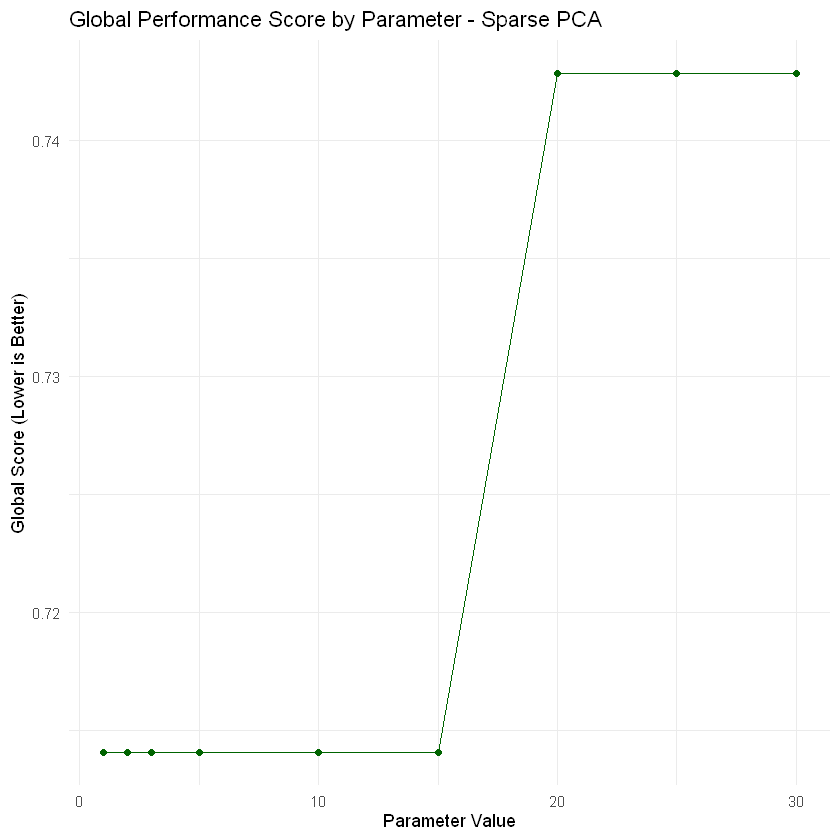

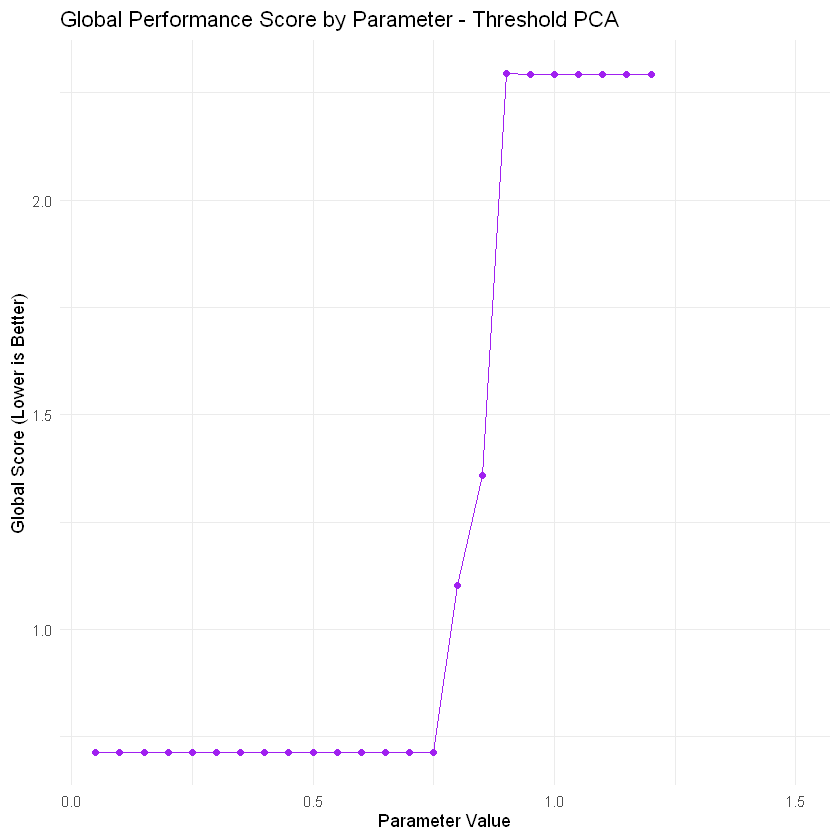

In [80]:
# Sparse PCA
sparsePCA <- allResults %>% filter(Method == "Sparse PCA")
ggplot(sparsePCA, aes(x = Parameter, y = Global_Score)) +
  geom_line(color = "darkgreen") +
  geom_point(color = "darkgreen") +
  labs(title = "Global Performance Score by Parameter - Sparse PCA",
       x = "Parameter Value",
       y = "Global Score (Lower is Better)") +
  theme_minimal()

# Threshold PCA
thresholdPCA <- allResults %>% filter(Method == "Threshold PCA")
ggplot(thresholdPCA, aes(x = Parameter, y = Global_Score)) +
  geom_line(color = "purple") +
  geom_point(color = "purple") +
  labs(title = "Global Performance Score by Parameter - Threshold PCA",
       x = "Parameter Value",
       y = "Global Score (Lower is Better)") +
  theme_minimal()

Warning message:
"Removed 1 row containing missing values or values outside the scale range (`geom_bar()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range (`geom_point()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range (`geom_line()`)."


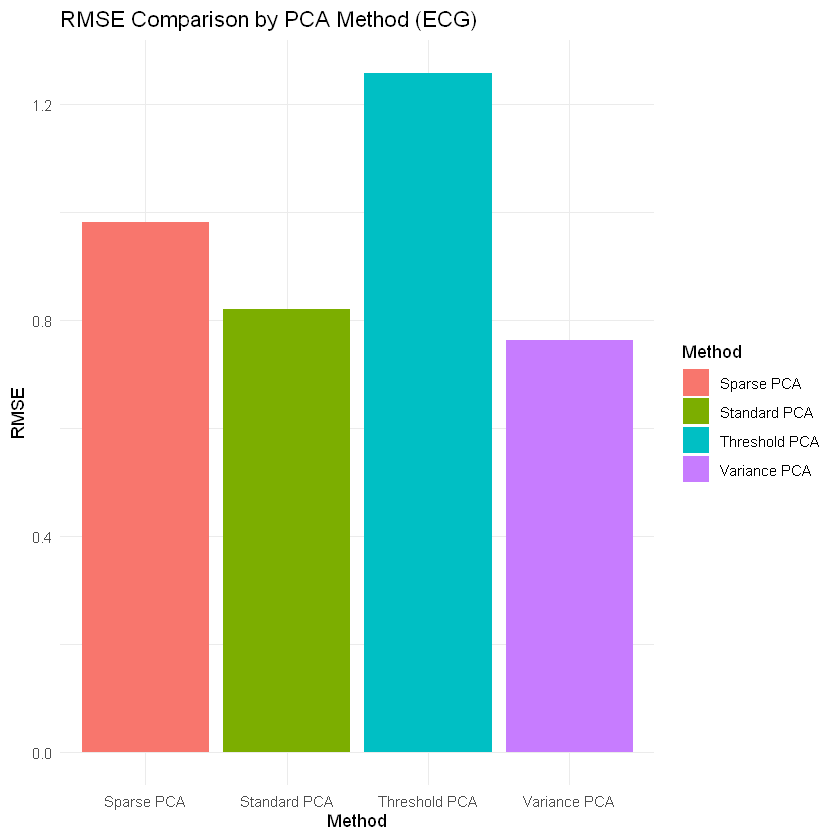

Warning message:
"Removed 1 row containing missing values or values outside the scale range (`geom_line()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range (`geom_point()`)."


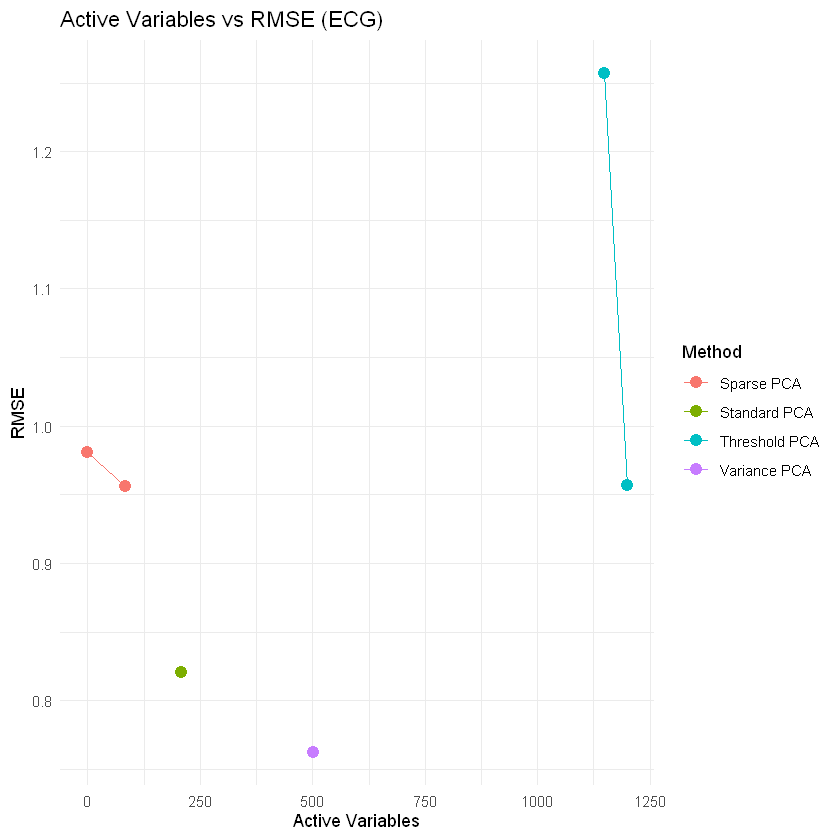

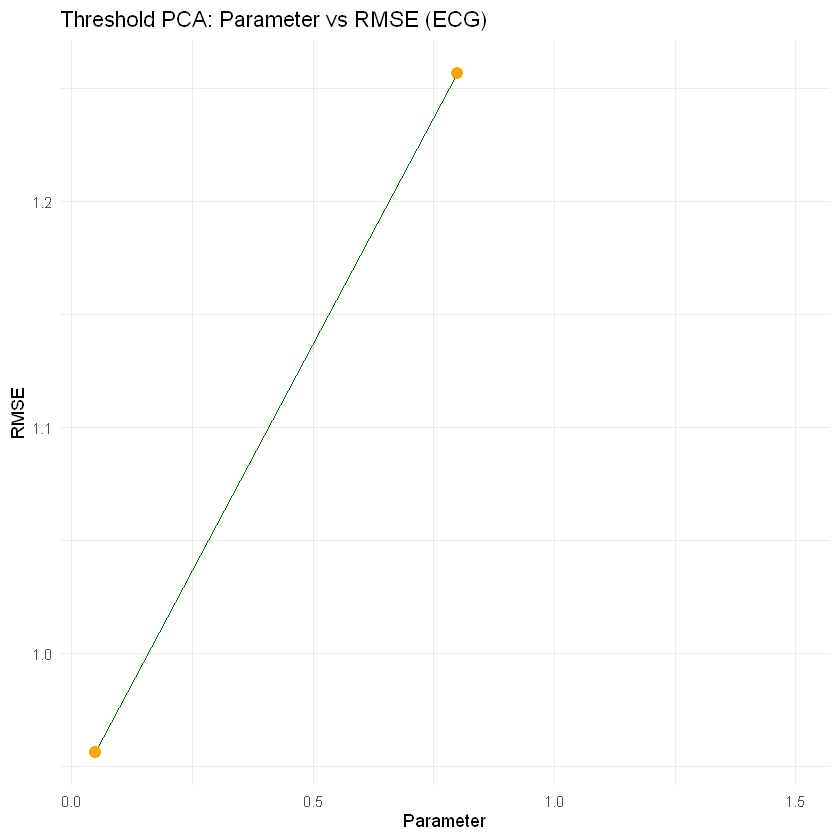

In [84]:
# Load libraries
library(ggplot2)
library(dplyr)

# Data setup
results_ecg <- data.frame(
  Method = c("Standard PCA", "Variance PCA", "Sparse PCA", "Sparse PCA", 
             "Threshold PCA", "Threshold PCA", "Threshold PCA"),
  Parameter = c(0.00, 0.00, 1.00, 20.00, 0.05, 0.80, 1.50),
  RMSE = c(0.8210, 0.7627, 0.9561, 0.9806, 0.9566, 1.2566, NA),
  NMSE = c(0.2005, 0.5829, 0.2719, 0.2860, 0.2722, 0.4697, NA),
  ActiveVariables = c(209, 501, 84, 0, 1200, 1149, 0),
  Global_Score = c(0.5652, 0.6424, 0.7141, 0.7428, 0.7146, 1.1018, NA)
)

# 1. Bar plot of RMSE by method
ggplot(results_ecg, aes(x = Method, y = RMSE, fill = Method)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(title = "RMSE Comparison by PCA Method (ECG)", x = "Method", y = "RMSE") +
  theme_minimal()

# 2. Active Variables vs RMSE
ggplot(results_ecg, aes(x = ActiveVariables, y = RMSE, color = Method)) +
  geom_point(size = 3) +
  geom_line() +
  labs(title = "Active Variables vs RMSE (ECG)", x = "Active Variables", y = "RMSE") +
  theme_minimal()

# 3. Threshold PCA: Parameter vs RMSE
threshold_ecg <- results_ecg %>% filter(Method == "Threshold PCA")

ggplot(threshold_ecg, aes(x = Parameter, y = RMSE)) +
  geom_line(color = "darkgreen") +
  geom_point(size = 3, color = "orange") +
  labs(title = "Threshold PCA: Parameter vs RMSE (ECG)", x = "Parameter", y = "RMSE") +
  theme_minimal()


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


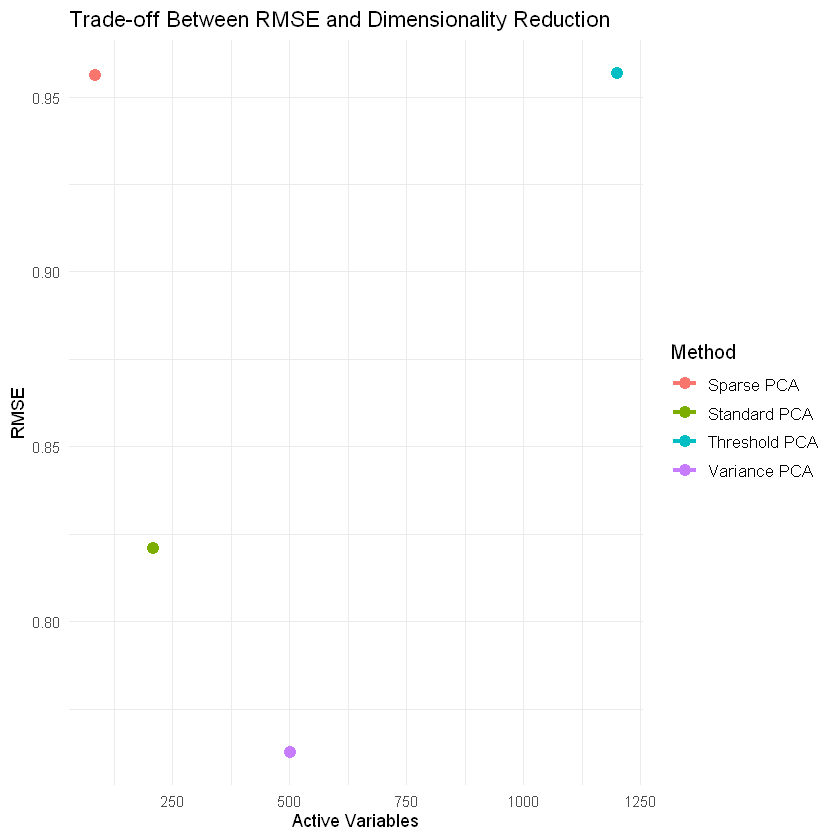

In [94]:
# Charger les bibliothèques
library(ggplot2)
library(dplyr)

# Préparation des données
data <- data.frame(
  Method = c("Standard PCA", "Variance PCA", "Sparse PCA", "Threshold PCA"),
  RMSE = c(0.8210, 0.7627, 0.9561, 0.9566),
  ActiveVariables = c(209, 501, 84, 1200)
)

# Graphique comparatif
ggplot(data, aes(x = ActiveVariables, y = RMSE, color = Method)) +
  geom_line(size = 1.2) +  # Lignes pour chaque méthode
  geom_point(size = 3) +   # Points pour les données
  labs(
    title = "Trade-off Between RMSE and Dimensionality Reduction",
    x = "Active Variables",
    y = "RMSE",
    color = "Method"
  ) +
  theme_minimal() +
  theme(
    legend.position = "right",
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 10)
  )


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


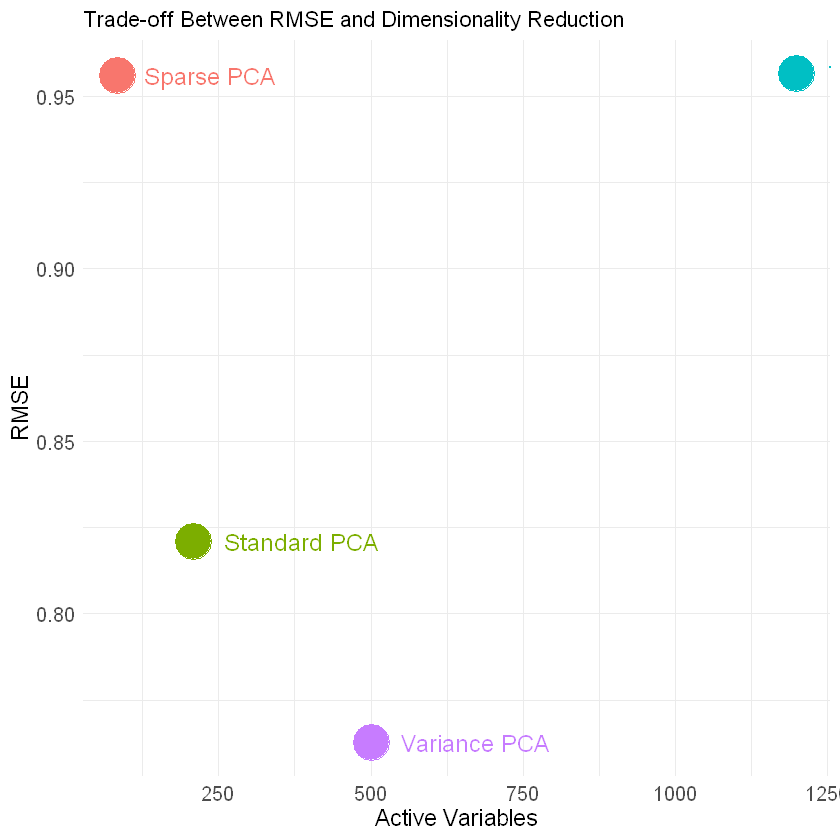

In [98]:
# Charger les bibliothèques
library(ggplot2)
library(dplyr)

# Préparation des données
data <- data.frame(
  Method = c("Standard PCA", "Variance PCA", "Sparse PCA", "Threshold PCA"),
  RMSE = c(0.8210, 0.7627, 0.9561, 0.9566),
  ActiveVariables = c(209, 501, 84, 1200)
)

# Graphique comparatif
ggplot(data, aes(x = ActiveVariables, y = RMSE, color = Method)) +
  geom_line(size = 1.2, show.legend = FALSE) +  # Lignes pour le contexte
  geom_point(size = 10) +  # Points beaucoup plus gros
  geom_text(aes(label = Method), hjust = -0.2, vjust = 0.5, size = 5, show.legend = FALSE) + # Noms des méthodes
  labs(
    title = "Trade-off Between RMSE and Dimensionality Reduction",
    x = "Active Variables",
    y = "RMSE",
    color = "Method"
  ) +
  theme_minimal() +
  theme(
    legend.position = "none",  # Supprime la légende car les noms sont sur le graphique
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12)
  )


In [100]:
ggsave(
  filename = "PCA_ECG_Tradeoff.jpg",
  plot = last_plot(),
  device = "jpeg",
  width = 10,
  height = 7,
  dpi = 300
)


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
